In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network trained on selected features to descirbe degree of loss for HCMC

The chance of loss is predicted by classifier. The target_degree variable to predict by the BN are the the degree of relative content loss [fraction of content loss and total content value ] for microbusinesses . \
The transferability of the classifer and the BN is tested on the Can Tho dataset

Abbreviations in variables for chance and degre of loss
c = "chance of loss"
d = "degree of loss"
cd = contains "change and degree of loss"

BN package: https://github.com/mike-mendoza/py_banshee

In [9]:
import sys, os
# import logging
import numpy as np
import pandas as pd
from joblib import load
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import figures as f
import evaluation_utils as eu
import settings as s
import preprocessing as pp


seed = s.seed
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

## observed losses
targets = [("degree of rcloss", "degree of rcloss"), ("rbred","rbred")]
target_degree, target_plot = targets[0]
target_chance = "chance of rcloss"
target_rcloss = "rcloss"  

## predicted losses for chance and degree of rlcoss
pred_target_degree = f"pred_{target_degree}"
pred_target_chance = f"pred_chance of rcloss"
pred_target_rcloss  = "pred_rcloss"


## save models and their evaluation in following folders:
INPATH_DATA = Path(f"../{s.INPATH_DATA}")
OUTPATH_CHANCE, OUTPATH_DEGREE, OUTPATH_FINALMODELS, OUTPATH_BN = [ # create output paths
    pp.create_output_dir( ".." / Path(d) ) for d in  
    [ s.OUTPATH_FEATURES + "chance_of_rcloss", s.OUTPATH_FEATURES + "degree_of_rcloss", 
     s.OUTPATH_FINALMODELS + "chance_of_rcloss" , s.OUTPATH_BN + "rcloss"]
]


Create ..\..\model_results\selected_features\chance_of_rcloss
Create ..\..\model_results\selected_features\degree_of_rcloss
Create ..\..\models_trained\final_models\chance_of_rcloss
Create ..\..\model_results\bayesian_network\rcloss


In [10]:
#type(OUTPATH_DEGREE)

In [11]:
## train set for BN degree of loss (HCMC)
target_name = "degree of rcloss"
df_hcmc_incl_zero = pd.read_excel(OUTPATH_DEGREE + f"./final_predictors_rcloss.xlsx")


# change target_degree name for component for rclsos "degree of rcloss" in  s.feature_names_plot 
s.feature_names_plot["target_relative_contentloss_euro"]  = "degree of rcloss"

##  use nice feature names
df_hcmc_incl_zero.rename(columns=s.feature_names_plot, inplace=True) 
# FIXME workaround change feature names in settings
try:    df_hcmc_incl_zero.rename({"water depth inside": "water depth"}, axis=1, inplace=True)
except:   pass

## better for merging different sources, when indexes are all the same
df_hcmc_incl_zero.reset_index(drop=True, inplace=True) 

## DF of  degree of rcloss (inlc incomplete cases)
df_hcmc_d = df_hcmc_incl_zero.loc[df_hcmc_incl_zero[target_rcloss] > 0.0, :]
## renmae of target
df_hcmc_d.rename(columns={"rcloss":"degree of rcloss"}, inplace=True)

## DF of chance of rcloss
## LogReg can only use complete sampels , therefore BN has also to predcit only on complete cases
## TODO merge of chance and degree - needs to be done on complete cases
## init df to store later all results from chance and degre of loss, as well as final vulnerability estimation (rcloss)
df_hcmc_pred_cd = df_hcmc_incl_zero.copy()
df_hcmc_pred_cd.dropna(inplace=True) 



print(df_hcmc_d.shape)
df_hcmc_d.tail(2)


df_hcmc_incl_zero.shape

(129, 15)


(320, 15)

In [12]:
df_hcmc_d.describe()

,degree of rcloss,mthly. sales,building age,mthly. income,flow velocity,water depth,non-structural measures,inundation duration,flood experience,no. employees,resilience,contaminations,emergency measures,building area,structural measures
count,129.000000,129.000000,124.000000,123.000000,129.000000,129.000000,129.000000,124.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,12.283580,323.307752,19.830645,428.137398,0.338760,39.023256,0.344961,12.592742,85.837209,1.751938,2.724806,1.031008,0.449612,80.975194,0.197674
std,20.367637,274.037323,12.507378,306.378476,0.122034,28.323595,0.272778,31.336708,52.895798,0.910280,1.006738,0.413408,0.251389,61.613599,0.275416
min,0.179416,92.100000,0.000000,110.500000,0.100000,2.000000,0.000000,0.500000,3.000000,1.000000,1.000000,0.000000,0.000000,15.000000,0.000000
25%,1.350520,92.100000,12.000000,294.600000,0.200000,20.000000,0.250000,2.000000,36.000000,1.000000,2.000000,1.000000,0.333333,45.000000,0.000000
50%,3.997393,276.200000,18.000000,294.600000,0.300000,40.000000,0.250000,3.000000,76.000000,2.000000,2.750000,1.000000,0.500000,65.000000,0.000000
75%,10.797306,276.200000,24.000000,552.400000,0.400000,50.000000,0.500000,8.000000,151.000000,2.000000,3.500000,1.000000,0.666667,98.000000,0.500000
max,93.505318,1473.000000,62.000000,2393.700000,0.500000,150.000000,1.000000,240.000000,151.000000,4.000000,5.000000,2.000000,1.000000,400.000000,1.000000


### explore condtional correlations

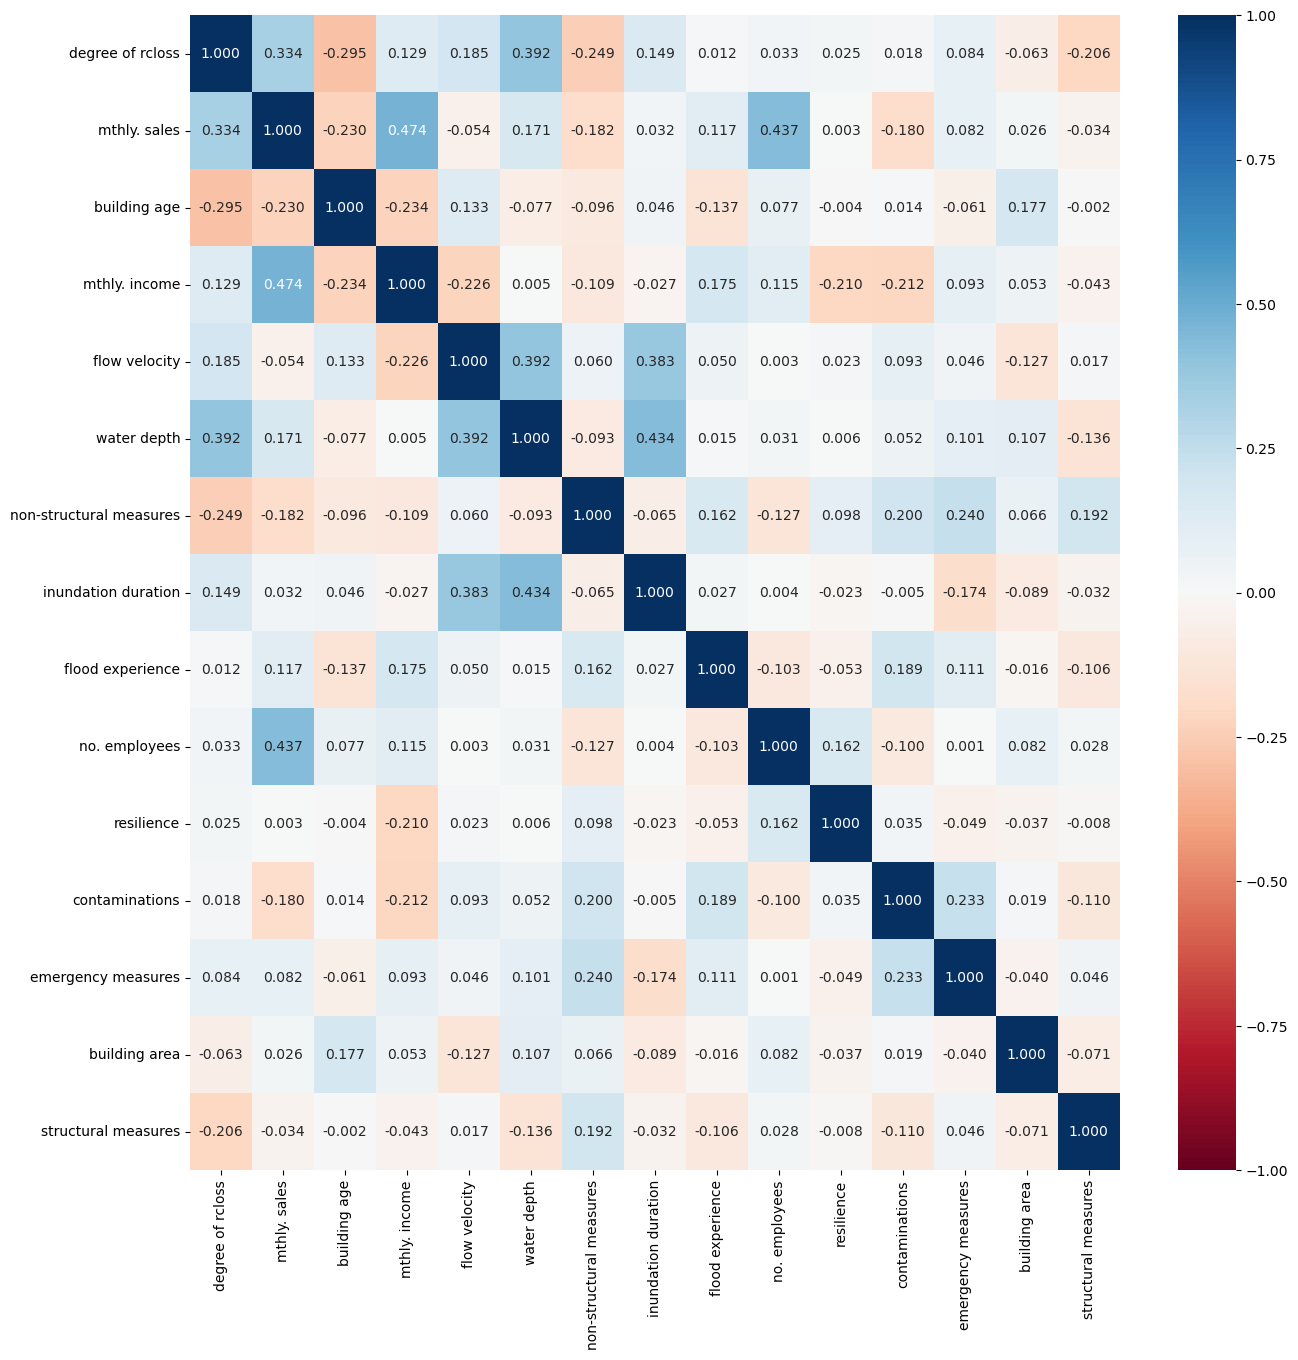

In [13]:
## find predictor with highest unconditional correlation to target_rcloss
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc_d.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")


--> water depth correlates strongest with degree of rcloss

## Construct BN

In [14]:
df_hcmc_d.columns

Index(['degree of rcloss', 'mthly. sales', 'building age', 'mthly. income',
       'flow velocity', 'water depth', 'non-structural measures',
       'inundation duration', 'flood experience', 'no. employees',
       'resilience', 'contaminations', 'emergency measures', 'building area',
       'structural measures'],
      dtype='object')

In [15]:
# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target_degree}"

# Define the variable names
# names_list = ["target_relative_contentloss_euro", "water_depth_cm", "b_area"]# inundation_duration_h
print(df_hcmc_d.columns)

names_list = [
    "degree of rcloss", "water depth", 
    "mthly. sales", "building age", #"flow velocity" #"precautionary_measures_lowcost"
    "structural measures", "non-structural measures",
    # "resilience"
   # "no. employees", #"flow velocity"
    # "mthly. income"
    # "water_depth_cm", "precautionary_measures_lowcost", #"b_area", "emergency_measures"
    # "precautionary_measures_expensive", #"inundation_duration_h"
    ]


## NOTE
# fv and fe no improvement as 4th parent node, also with income no imporvement as 4th or 5th,
# same for emergency - shows high level of FE and adapted usage anyway
## keep non-struc ~ wd despite -0.06 cond. rank corr- due that logical explainable


## org
# names_list = [
#     "target_relative_contentloss_euro", "flowvelocity", 
#     "mthly. sales", "bage", #"precautionary_measures_lowcost"
#     "water_depth_cm", "precautionary_measures_lowcost", #"b_area", "emergency_measures"
#     "precautionary_measures_expensive", #"inundation_duration_h"
#     ]


## bage -> prec : 
## old building:inhabitant have practice in effective flood-adaption measres for their bui. + newe buis might located in rather floodprone areas
## DONE check inund.map if newer buis are located more in floodprone areas -> might expl bage -> -rcloss = NOPE no visible relationship
## TODO which shp have highest sale rates? are these services or spec. shps? -> might expl sales -> - prec-cheap = services and production have highest sale rates (higher than shops/retailers)
## --> higher sale rates -> less cheap meausres mainly done services and production sites (shops/retailers tend to impl more cheap measures, have lower sale rates),
## TODO  bage -> - rcloss (not explainable that newer bui in more floodprone areas) , idea bui owner have more experience which measures help
## -> bred: How strongly was your monthly sale/ production reduced during the flood? 
## -> mth sales: What is your monthly sale in average?

## bage -> - sale rates, bage -> -rcloss 
## older buis whch were built before the city boom in late 80s are in less floodprone areas
## all buis build during city boom (late 80s- 2010) have much higher losses (siedlungsruck bewirkt ausweitung in niedrigere gebiete)

# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc_d[names_list]
 
names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['degree of rcloss', 'mthly. sales', 'building age', 'mthly. income',
       'flow velocity', 'water depth', 'non-structural measures',
       'inundation duration', 'flood experience', 'no. employees',
       'resilience', 'contaminations', 'emergency measures', 'building area',
       'structural measures'],
      dtype='object')
Using following features: {'degree of rcloss': 0, 'water depth': 1, 'mthly. sales': 2, 'building age': 3, 'structural measures': 4, 'non-structural measures': 5}


In [16]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target_degree
print(N)

# Defining the structure of the BN
parent_cell = [None]*N


# ### --- Schema kid_cell = parent_cells --- ###
parent_cell[0] = [1, 2, 3, 4, 5] #, 3, 4, 5, 6]                                            #   target_degree (parents: all other features)
parent_cell[1] = [ 4]  # wd
parent_cell[2] = []     # sale
parent_cell[3] = []     # bage
parent_cell[4] = []      # struc
parent_cell[5] = [2]
# parent_cell[7] = []

#  node 4 : fv no MAE imporvement, but storng corr with wd



## org
# parent_cell[0] = [1, 2, 3, 4, 5, 6]                                            #   target_degree (parents: all other features)
# parent_cell[1] = []
# parent_cell[2] = []
# parent_cell[3] = []
# parent_cell[4] = [1, 6]
# parent_cell[5] = [2 ]
# parent_cell[6] = []


# ## check conditional spearman correlations of features: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target_degree


parent_cell

6


[[1, 2, 3, 4, 5], [4], [], [], [], [2]]

<Figure size 500x500 with 0 Axes>

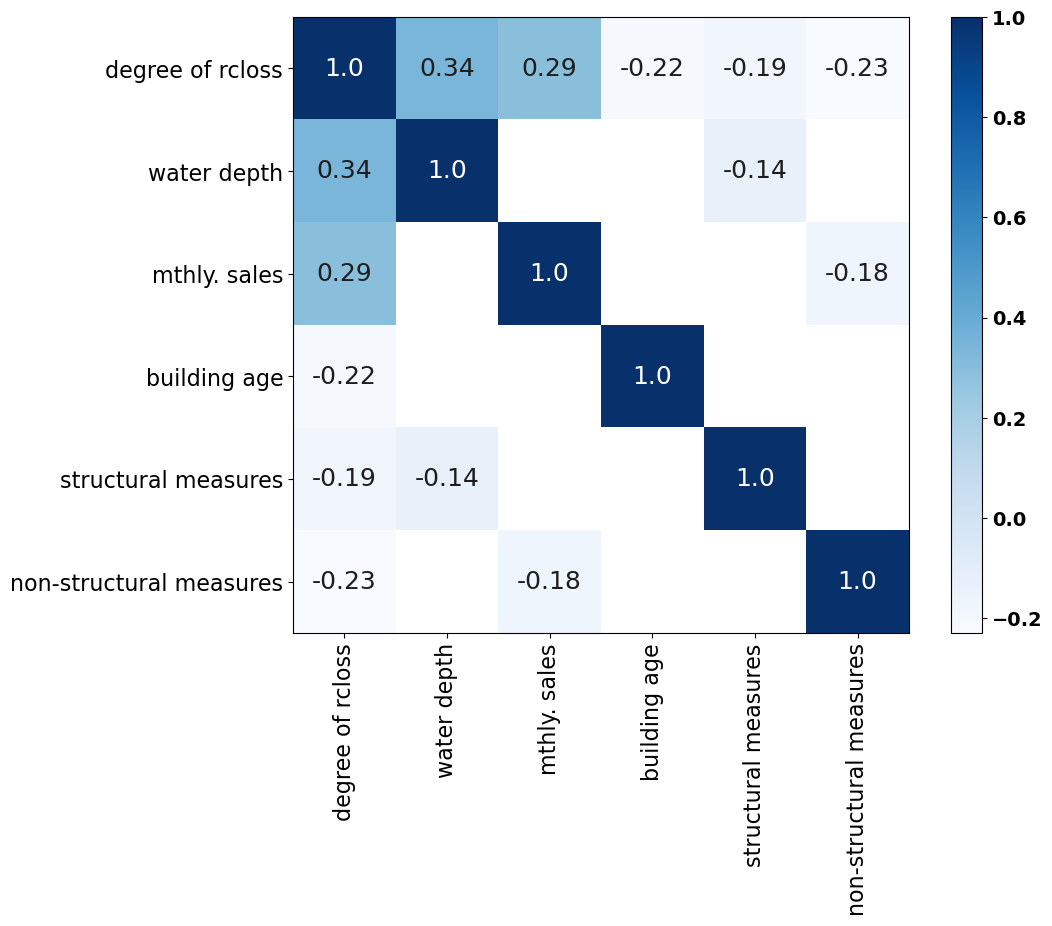

In [17]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

# The plot shows that target_degree has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.



### BN visualization

Index(['degree of rcloss', 'water depth', 'mthly. sales', 'building age',
       'structural measures', 'non-structural measures'],
      dtype='object')


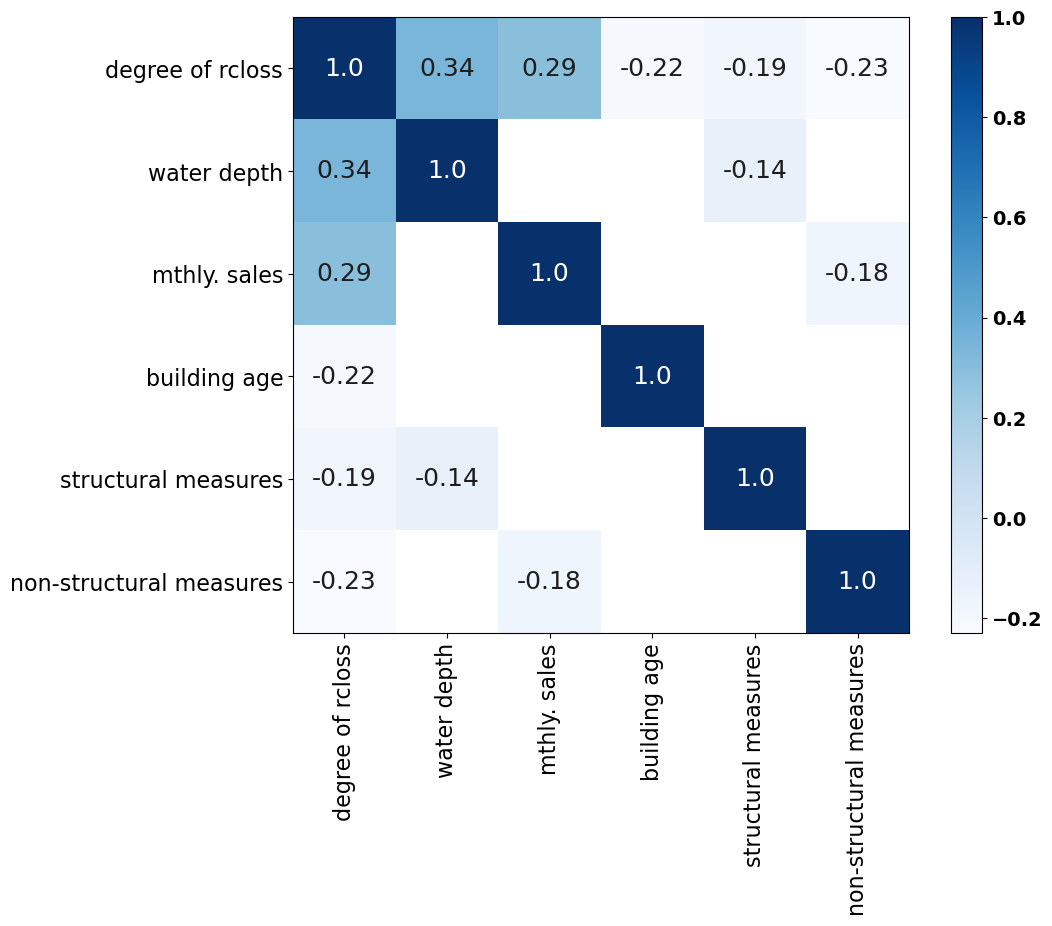

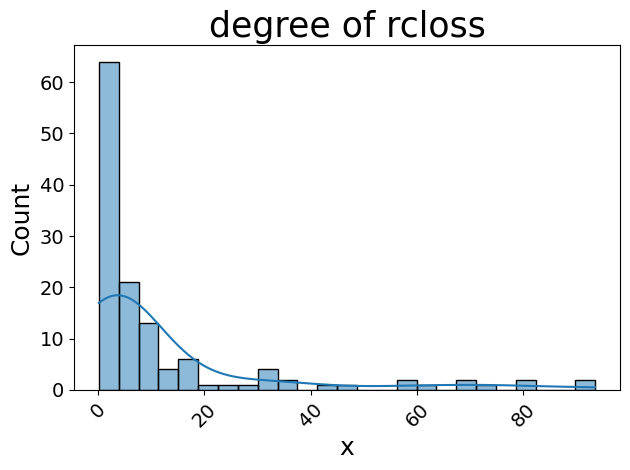

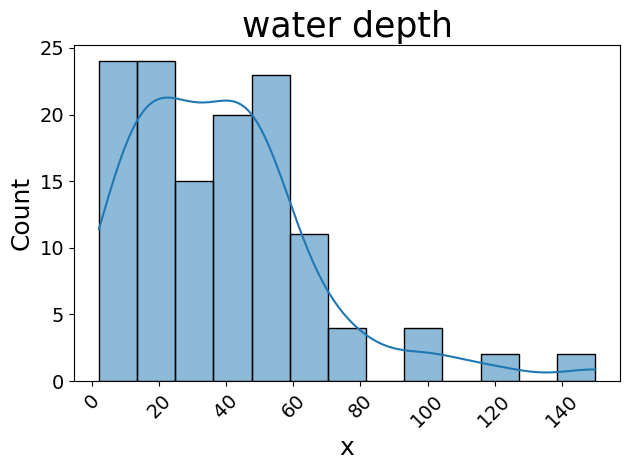

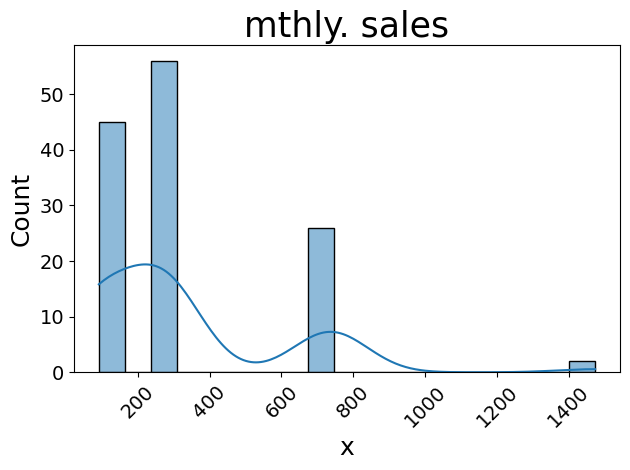

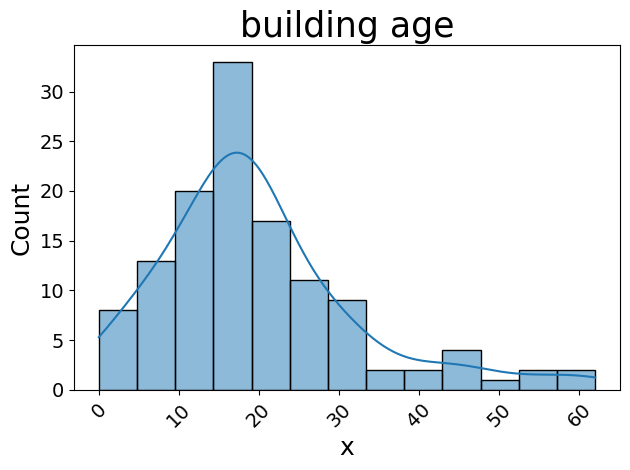

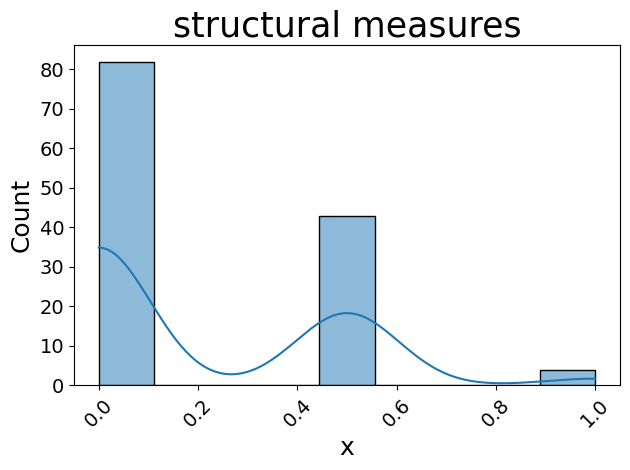

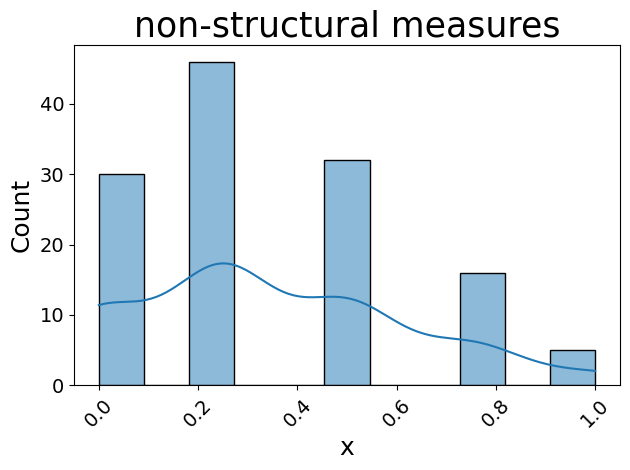

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\master thesis\\flood-loss-models-4-HCMC-remote\\improve-project\\bayesian-network\\BN_visualize_bn_structure_degree of rcloss_margins.pdf'

In [18]:
# #-----------------------------------------------------------------------------
# # Function 2 - bn_visualize - Plot of the Bayesian Network
# #-----------------------------------------------------------------------------
"""BN structure with graph + rank correlations on degree of loss samples"""

fig_name = f"bn_structure_{target_degree}"

print(df_hcmc_bn.columns)

df_hcmc_d_plot = df_hcmc_bn


R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d_plot,   # matrix of df_hcmc
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = True) 

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_d_plot.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with x nodes and x arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_d_plot.columns,                      # names of variables
             data = df_hcmc_d_plot,                       # DataFrame with data
             fig_name = fig_name + "_margins")  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


### Copula test

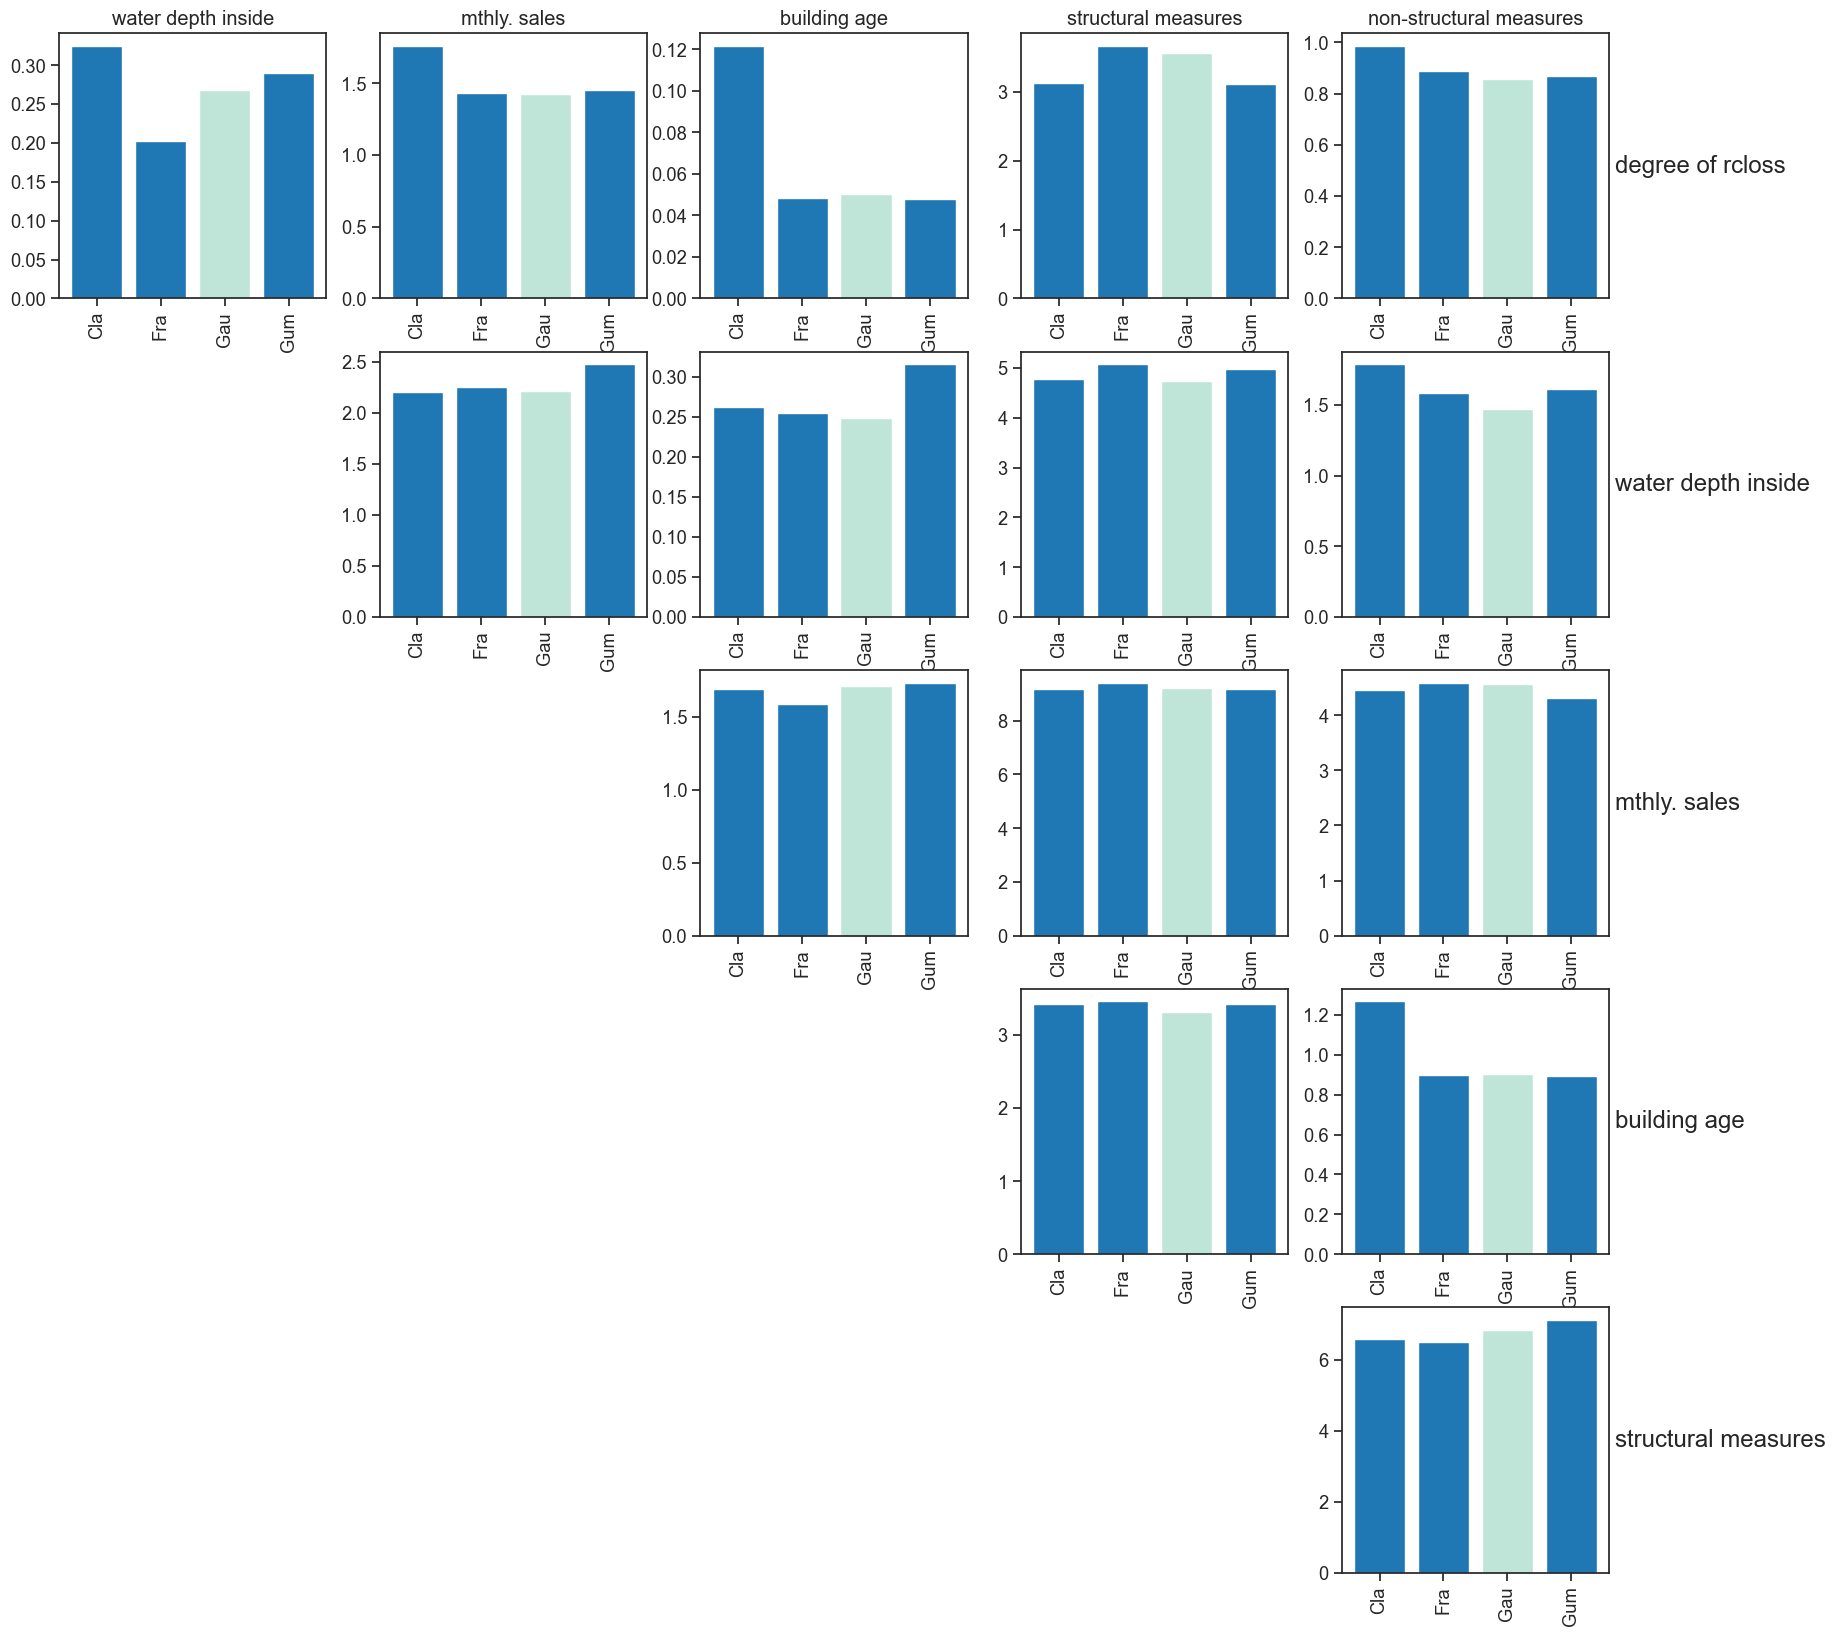

In [69]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
#                   names = df_hcmc.columns,   # names of variables
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don"t create plot)
                  fig_name = "empricial_corpula_all_vars_degree of rcloss")    # figure name
                                    # fig_name = fig_name)    # figure name

# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

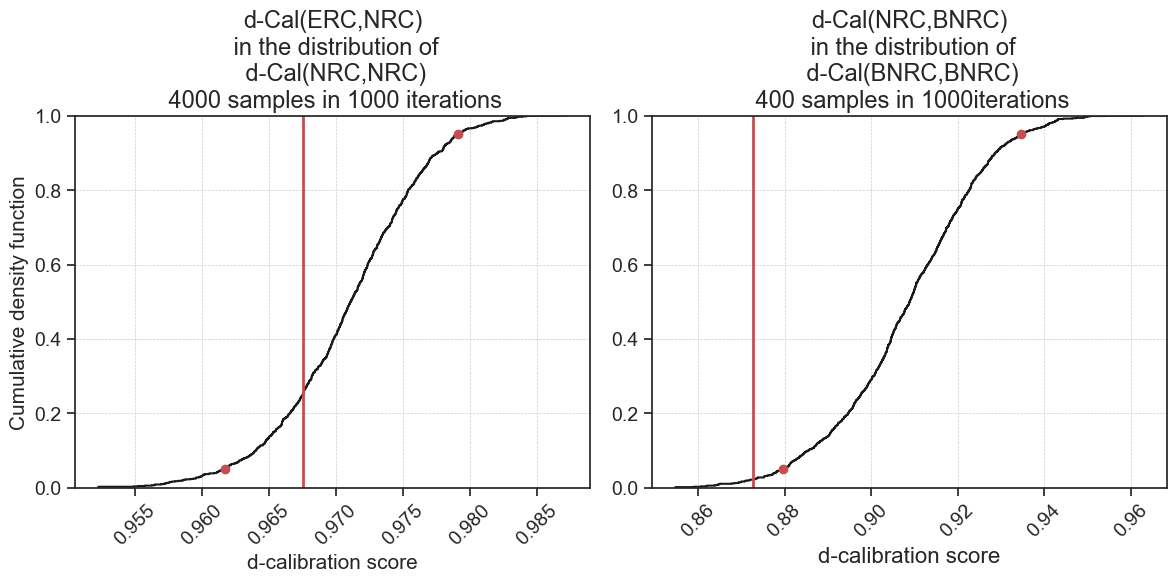

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [70]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------


# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don"t create plot)
                            Type="H",           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name


                   
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


## Evaluation of degree of damage

In [71]:
condition=[1, 2, 3, 4, 5]
# condition=[1, 2, 3, 4, 5, 6]
# condition=[1, 2, 3, 4, 5, 6, 7]

num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)

df_hcmc_d = df_hcmc_bn#.sample(frac=1).reset_index(drop=True)
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
results = pd.DataFrame()


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_d[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_d[ ~df_hcmc_d.index.isin(test_nth_fold.index)] # 80% train
    print(df_hcmc_d.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # derive rank correlations from training set of nth fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    # estimate loss on test set of nth fold
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        
                Output="mean")    # type of output data, return averge of 
                #Output="median")    # type of output data
 
    ## predict target_degree
    y_pred = F_test_nth_fold.squeeze()

    # observed target_degree
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    results_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    results = pd.concat([results, results_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    # print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    # print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

results.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = OUTPATH_BN + f"./bn_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = OUTPATH_BN + f"./bn_avg_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)

# 4 preds: 0  14.491298 -6.805579  17.791729  56.043545 

## pre_cheap
# no dep: 0  13.580885 -5.086162  17.560323  54.131192 
# sales -> pre: 0  12.576822 -3.864058  15.882124  53.329565 
# bage -> pre_cheap: weak corr < 0.10
# pre_cheap -> wd: weak corr < 0.10
# bage -> pre_exp: weak corr < 0.10 (same for sale rates)
# sale-> bage, (sale,bage) -> pre: 0  12.011064 -3.072826  15.944509  53.560565 
# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


# 0  12.414802  2.035223  17.530051  50.848003  # bage -> degree
# 0  12.038915  0.938854  17.720844  50.656139  # bage -> wd, bage->sates  # bage-fv not improve
# 0  11.975276  0.92388  17.617169  50.7071  # bage -> sales


# 0  12.745006  2.982842  17.701319  51.809956 
# 0  12.046735  0.404458  18.258643  49.873463 


(129, 6) (104, 6) (25, 6)
(129, 6) (104, 6) (25, 6)
(129, 6) (104, 6) (25, 6)
(129, 6) (104, 6) (25, 6)
(129, 6) (104, 6) (25, 6)
Averaged evaluation scores of k-fold cross-validation (mean) :
          MAE       MBE       RMSE      SMAPE
0  13.962921  3.837749  22.110805  49.883944 
..saved to ..\..\model_results\bayesian_network\rcloss./bn_performance_bn_degree_degree of rcloss_hcmc.xlsx


### plot obs ~ pred

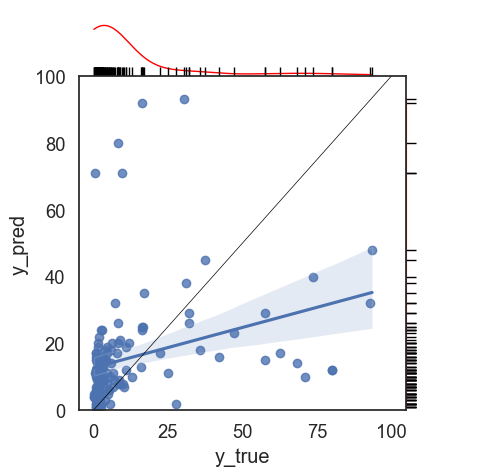

In [72]:
sns.set(style="white", font_scale=1.2)
g = sns.JointGrid(
    x=results["y_true"], y=results["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color="black", #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={"color": "red", "cut": 0.0, "lw": 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0, 100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

## Bn degree: 
- can capture very small loss ratios (over estimates them)
- regronize higher losses ratios as such but still under estimates them strongly
- 5-fold ccv: 0  11.888496 -1.900096  17.141786  51.108436 


In [73]:
# bins = np.linspace(0, 100, 100)

# plt.hist(results["y_true"], bins, alpha=0.7, label="empirical")
# plt.hist(results["y_pred"], bins, alpha=0.7, label="predicted")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for degree of loss for HCMC")
# plt.xlim(0,100)
# plt.show()


In [74]:
print(results.describe())


           y_true      y_pred
count  125.000000  125.000000
mean    12.410058   15.728000
std     20.660771   16.434315
min      0.179416    1.000000
25%      1.350520    7.000000
50%      3.617408   11.000000
75%     10.128713   18.000000
max     93.505318   93.000000


# Rcloss estimation

Predict chance and degree of loss on holdout set of HCMC, which was kept unseen from ML and BN models


In [75]:
# df_hcmc_Xy =  df_hcmc.dropna().drop(["geometry", target_degree], axis=1)  # drop incomplete records and geom col, needed for Logistic Regression model
# df_hcmc_y = df_hcmc_Xy[target_degree] 
# df_hcmc_X = df_hcmc_Xy[["inundation_duration_h",
#        "water_depth_cm", "flowvelocity", "contaminations", "flood_experience",
#        "bage", "b_area", "emergency_measures",
#        "precautionary_measures_lowcost", "precautionary_measures_expensive",
#        "shp_employees", "resilience", "mthly. sales"]]  # get vars in same order as during fit


## get chance of loss - HCMC
get predicted probabilities from nested cv , these are the predictions done on the outer test sets

In [76]:
os.getcwd()

'c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\master thesis\\flood-loss-models-4-HCMC-remote\\improve-project\\bayesian-network'

In [77]:
## load estimated probabilities for chance of loss from ncv
df_hcmc_c  = pd.read_excel(OUTPATH_CHANCE + f"./predictions_chance_of_rcloss.xlsx")
#df_hcmc_c  = pd.read_excel("predictions_chance_of_rcloss.xlsx")
 # f"predictions_target_relative_contentloss_euro.xlsx")
print(df_hcmc_c.shape)

##  update probability column in respect to y_pred, 
## currently zero-loss cases have also probability between 0.5 - 1.0 % --> should be 0.0 - 0.49 %: if ypred == 0 --> then proba should be 1.0 -> 0.0 ; 0.98 -> 0.02  [old proba -> new proba]
df_hcmc_c = eu.reverse_probability_scores(df_hcmc_c, "y_proba", ("y_pred", 0.0))
df_hcmc_c#["y_proba"]#.describe()

# ## add chance of loss as column to results df
# df_hcmc_pred_cd[f"chance_pred_proba"] =  df_hcmc_c["y_proba"]
# df_hcmc_pred_cd[f"{pred_target_chance}_binary"] =  df_hcmc_c["y_pred"]
# df_hcmc_pred_cd[pred_target_degree] =  0.0

(287, 6)


,Unnamed: 0,y_true,y_pred,y_proba,residual,y_true_rcloss
0,0,0,0,0.417,0,0.0
1,1,0,1,0.501,-1,0.0
2,2,0,0,0.153,0,0.0
3,3,0,0,0.175,0,0.0
4,4,0,0,0.326,0,0.0
...,...,...,...,...,...,...
282,315,0,0,0.270,0,0.0
283,316,0,0,0.363,0,0.0
284,317,0,0,0.427,0,0.0
285,318,0,0,0.269,0,0.0


In [78]:
# df_hcmc_pred_cd
df_hcmc_c.describe()

pred_target_chance

'pred_chance of rcloss'

In [79]:

## add chance of loss as column to results df
df_hcmc_pred_cd["chance of rcloss"] = df_hcmc_pred_cd["rcloss"]
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["chance of rcloss"] > 0.0, "chance of rcloss"] = 1.0
df_hcmc_pred_cd[pred_target_chance]= 0.0 ## NOTE keep as 0.0 to join with floats of y_pred, otherwise multiplcation with degree of rcloss does not work
df_hcmc_pred_cd[f"{pred_target_chance}_binary"]= None 
df_hcmc_pred_cd[pred_target_chance][:] =  df_hcmc_c["y_proba"][:]  # pred. probas of chance,  join by neglecting different indices
df_hcmc_pred_cd[f"{pred_target_chance}_binary"][:] =  df_hcmc_c["y_pred"][:]  # pred. single values [0,1] of chance,  join by neglecting different indices
#df_hcmc_pred_cd[f"predicted chance of closs"]
df_hcmc_pred_cd.describe()#[f"chance_pred_proba"]

,rcloss,mthly. sales,building age,mthly. income,flow velocity,water depth inside,non-structural measures,inundation duration,flood experience,no. employees,resilience,contaminations,emergency measures,building area,structural measures,chance of rcloss,pred_chance of rcloss
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,5.003009,364.421254,19.989547,427.925087,0.311847,31.560976,0.384146,8.779443,83.595819,1.790941,2.674216,0.982578,0.422764,75.047038,0.238676,0.393728,0.379387
std,14.678248,471.987366,14.254550,390.692022,0.126543,24.399407,0.296898,23.660051,53.689118,1.086240,1.016970,0.413551,0.266886,47.971471,0.276723,0.489429,0.142254
min,0.000000,92.100000,0.000000,110.500000,0.100000,1.000000,0.000000,0.200000,3.000000,1.000000,0.500000,0.000000,0.000000,12.000000,0.000000,0.000000,0.063000
25%,0.000000,92.100000,12.000000,294.600000,0.200000,10.000000,0.250000,2.000000,36.000000,1.000000,1.875000,1.000000,0.166667,42.000000,0.000000,0.000000,0.274500
50%,0.000000,276.200000,18.000000,294.600000,0.300000,30.000000,0.250000,3.000000,76.000000,2.000000,2.750000,1.000000,0.500000,65.000000,0.000000,0.000000,0.375000
75%,2.131646,276.200000,24.000000,552.400000,0.400000,50.000000,0.500000,5.000000,151.000000,2.000000,3.500000,1.000000,0.666667,96.000000,0.500000,1.000000,0.474500
max,93.505318,2761.900000,100.000000,3314.300000,0.500000,150.000000,1.000000,240.000000,151.000000,7.000000,5.000000,2.000000,1.000000,350.000000,1.000000,1.000000,0.804000


Actual zero-loss: 174 
Actual damage: 113 

Predict as zero-loss: 229 
Predict as damage: 58 


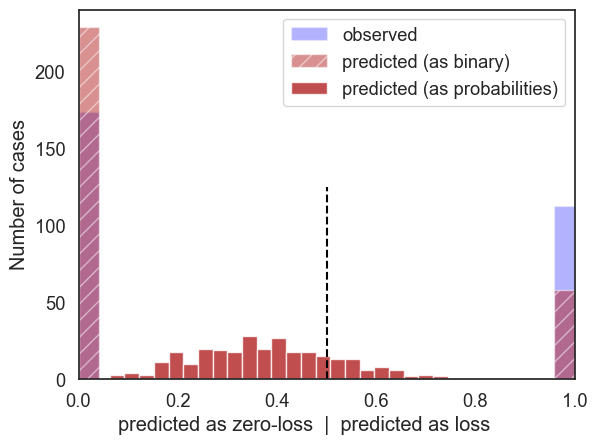

In [97]:
df_hcmc_c_pred = df_hcmc_pred_cd[f"{pred_target_chance}_binary"]
df_hcmc_c_proba = df_hcmc_pred_cd[pred_target_chance]
df_hcmc_c_true = df_hcmc_pred_cd["chance of rcloss"]

print(f"Actual zero-loss: {len(np.where(df_hcmc_c_true == 0)[0])} \nActual damage: {df_hcmc_c_true[df_hcmc_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_hcmc_c_pred == 0)[0])} \nPredict as damage: {len(np.where(df_hcmc_c_pred == 1)[0])} ")


bins = np.linspace(0, 1, 25)
plt.hist(df_hcmc_c_true, bins, alpha=0.3, label="observed", color="blue")
plt.hist(df_hcmc_c_pred, bins, alpha=0.5, label="predicted (as binary)", color="firebrick", hatch="//")
plt.hist(df_hcmc_c_proba, 25, alpha=0.8, label="predicted (as probabilities)", color="firebrick")
plt.legend(loc="upper right")
# plt.title("Distributions of probability estimates for chance of rcloss (HCMC)")
plt.xlim(0,1)
plt.xlabel("predicted as zero-loss  |  predicted as loss        ")
plt.ylabel("Number of cases")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")

plt.savefig(OUTPATH_BN + "./histo_LR_proba_estimates.png", dpi=300, bbox_inches="tight")

plt.show()



## predict degree of loss - HCMC


In [23]:
df_hcmc_bn[names_list].shape

(129, 6)

In [24]:
# condition=[1, 2]
condition=[1, 2, 3, 4 ,5]

## select only variables used in BN
df_hcmc_d = df_hcmc_bn[names_list]

num_folds = 3
testset_size = int( len(df_hcmc_d) / num_folds  // 1)

df_hcmc_d = df_hcmc_d#.sample(frac=1).reset_index(drop=True)
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
degree_results = pd.DataFrame()  # store y_true and y_pred 

print(f"all samples and variables used for entire CV: {df_hcmc_d.shape}")


for i in range(num_folds):

    # ## split Fold into train and test
    test_nth_fold = df_hcmc_d[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_d[ ~df_hcmc_d.index.isin(test_nth_fold.index)] # 80% train
    print(df_hcmc_d.shape , train_nth_fold.shape, test_nth_fold.shape)
    print("\ntraining and test samples for {i} fold: {train_nth_fold.shape[0], test_nth_fold.shape[0]}")

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        # DataFrame with df_hcmc
                Output="mean")    # type of output data
                #Output="median")    # type of output data
 
    ## predict target_degree
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.loc[:,target_degree].to_numpy()

    ## store for plotting obs ~ pred
    results_per_fold = pd.concat([pd.Series(y_true).round(2), pd.Series(y_pred).round(2)], axis=1)
    degree_results = pd.concat([degree_results, results_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"\nScores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())



# print(y_pred, y_true)

# init df to store obs+predictions, use idx from DF degree
degree_results.columns = ["y_true", "y_pred"]
degree_results.index = df_hcmc_d.index
degree_results.index

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = OUTPATH_BN + f"./bn_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = OUTPATH_BN + f"./bn_avg_performance_bn_degree_{target_degree}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)




# median used for inference: 0  9.224541 -6.125418  18.073158  40.912663 
# mean used for inference: 0  13.089186 -3.005923  18.264466  55.655292 (inc fv)


all samples and variables used for entire CV: (129, 6)
(129, 6) (86, 6) (43, 6)

training and test samples for {i} fold: {train_nth_fold.shape[0], test_nth_fold.shape[0]}

Scores from fold 0: 12.553294447787506 2.6144114453272653 20.21305403998334 55.77152370858446
Inference - Uncertainty distribution, fold 0:  count    43.000000
mean     13.766343
std      13.226160
min       1.815961
25%       6.422661
50%      10.709420
75%      17.201309
max      80.097828
dtype: float64
(129, 6) (86, 6) (43, 6)

training and test samples for {i} fold: {train_nth_fold.shape[0], test_nth_fold.shape[0]}

Scores from fold 1: 19.076455436985302 5.4032843875044945 31.191321302211975 52.75910564853994
Inference - Uncertainty distribution, fold 1:  count    43.000000
mean     18.729909
std      22.550543
min       1.545155
25%       7.197104
50%      10.565207
75%      18.643128
max      92.949061
dtype: float64
(129, 6) (86, 6) (43, 6)

training and test samples for {i} fold: {train_nth_fold.shape[0], te

In [25]:
print(len(np.where(df_hcmc_incl_zero.dropna()[target_rcloss] > 0.0)[0]) ) # all observed damage-cases in HMCC

113


### get uncertainty in rel/abs bred predictions

In [26]:
condition = condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_hcmc_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_hcmc_bn.iloc[:,0].to_numpy()



In [27]:
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

df_uncertainties_avg = df_uncertainties

df_uncertainties_p = pd.DataFrame()
df_uncertainties_p["avg_modelled"] = df_uncertainties_avg.mean(axis=0)
df_uncertainties_p["observed"] = y_true
df_uncertainties_p["city"] = "HCMC"

df_uncertainties_p


,avg_modelled,observed,city
0,11.372222,0.920782,HCMC
1,1.545626,0.805886,HCMC
2,2.583880,0.805886,HCMC
3,38.135540,73.531408,HCMC
4,12.418042,0.799444,HCMC
...,...,...,...
124,48.996964,93.505318,HCMC
125,10.259064,4.051485,HCMC
126,14.522879,2.708237,HCMC
127,21.121111,14.796229,HCMC


In [28]:
degree_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 7 to 312
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_true  129 non-null    float64
 1   y_pred  129 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [29]:
import folium
map = folium.Map(location=[106.6637,10.6878], default_zoom_start=15)


In [30]:
df_uncertainties_avg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,10.797306,5.333285,0.799444,4.051705,5.333285,1.620612,8.386916,0.999312,8.976364,2.999151,2.708237,0.810306,22.193559,4.051529,8.976364,1.279545,0.897202,93.605318,2.708237,1.200252,1.779137,4.264425,0.203120,70.906425,0.822018,17.103276,2.025743,80.000543,5.358225,47.067890,8.386916,25.152974,2.673385,1.648853,1.620612,3.617408,14.796229,16.336720,8.168360,1.962158,0.999294,8.006118,2.237550,0.240050,17.103276,10.832946,1.779137,93.605318,2.999151,93.605318,2.708237,9.802032,5.572211,1.350520,16.336720,4.444954,3.997393,16.130869,3.004000,22.193559,0.598135,42.204119,8.248610,31.982838,4.444954,0.810306,0.810306,3.000597,0.541647,2.025743,2.850546,7.000489,2.673385,80.000543,93.605318,8.551638,0.799444,0.999294,57.629358,2.850546,1.350520,2.850546,9.802032,42.204119,0.810306,9.802032,0.822018,16.188738,57.629358,0.079416,2.237550,8.386916,4.480530,4.051485,10.128713,2.999151,1.648853,12.897185,37.398168,2.025743,93.605318,11.768570,8.249606,10.128713,0.799444,16.336720,68.288008,16.541299,17.103276,8.249606,8.551638,31.982838,4.450802,6.534688,73.531408,10.797306,4.444954,16.541299,4.264425,2.025743,0.822018,0.203120,8.551638,79.997828,31.982838,16.188738,5.333285,3.617408,9.078899
1,37.398168,1.083295,1.722954,4.444954,16.541299,1.722954,57.629358,0.999312,6.071797,30.267890,1.648853,0.598135,12.000348,16.336720,8.551638,12.897185,1.417477,93.605318,1.031880,0.203120,2.708237,2.025743,8.168360,16.130869,68.288008,0.810306,5.409174,93.605318,2.884404,1.620612,4.450802,14.796229,0.822018,1.350520,2.321729,5.333285,1.620612,5.409174,3.004000,2.321729,2.999151,2.237550,3.438157,0.897202,62.713150,7.239839,17.103276,93.605318,7.239839,93.605318,0.999312,12.000348,2.708237,0.799444,3.997393,1.031880,31.094678,31.094678,1.279545,9.679397,2.673385,12.897185,42.204119,93.605318,2.850546,6.576147,6.071797,8.249606,31.982838,70.906425,0.203120,57.629358,1.791345,0.810306,93.605318,1.546483,1.065838,2.025743,4.444954,5.774244,2.321729,1.791345,3.000597,8.249606,0.475209,2.708237,35.796251,0.810306,1.779137,0.920782,1.722954,10.797306,2.713056,68.288008,2.025743,68.288008,6.576147,1.031880,0.999294,1.279545,93.605318,57.629358,10.797306,1.031880,3.617408,8.168360,7.239839,4.051529,0.822018,12.897185,0.810306,1.779137,31.982838,4.051485,73.531408,1.031880,6.576147,3.299878,79.997828,6.534688,1.779137,0.999294,10.128713,30.267890,93.605318,0.475209,5.333285,1.083295,10.797306
2,3.438157,1.031880,1.620612,68.288008,1.083295,1.083295,16.188738,1.200252,10.797306,80.000543,1.648853,0.810306,8.249606,31.982838,4.799922,1.065838,0.799444,93.605318,7.239839,8.551638,0.920782,3.000597,4.444954,70.906425,6.071797,0.897202,0.999312,93.605318,2.025743,31.982838,22.193559,0.240050,8.248610,0.822018,1.279545,6.071797,0.999312,31.982838,57.629358,1.620612,1.350520,22.193559,1.962158,0.810306,8.168360,12.000348,9.078899,93.605318,0.920782,93.605318,16.541299,22.193559,0.960202,1.200252,4.444954,4.264425,4.051705,3.000597,0.799444,4.799922,0.598135,92.849061,3.997393,73.531408,3.299878,30.267890,2.328485,4.051485,0.079416,1.065838,3.438157,8.551638,3.324282,4.444954,93.605318,1.350520,0.240050,0.810306,0.897202,1.031880,4.444954,2.321729,93.605318,16.541299,1.648853,3.324282,2.700917,1.962158,1.620612,0.179416,0.810306,0.810306,1.962158,2.673385,10.128713,4.444954,12.000348,31.094678,7.239839,0.810306,93.605318,31.982838,8.168360,1.791345,12.000348,3.299878,57.629358,17.103276,10.832946,27.867890,4.480530,4.799922,79.997828,2.025743,70.906425,9.802032,8.551638,2.999151,8.976364,1.546483,1.962158,1.350520,8.976364,79.997828,93.605318,62.713150,31.094678

In [31]:
degree_results["y_pred"].describe()

count    129.000000
mean      16.046744
std       17.430506
min        1.550000
25%        6.720000
50%       11.300000
75%       18.250000
max       93.610000
Name: y_pred, dtype: float64

## get relative content loss estimations (chance * degree of loss)

**merge dfs for degree of rcloss with chance of rcloss **

In [32]:
## index of complete damage cases (no zero-losses and no incomplete cases)
idx_damage = df_hcmc_d.loc[~df_hcmc_incl_zero.isnull().any(axis=1)].index



## fill dummy df with degree of rcloss cases
## new col incl prediction of degree of loss, all zero-losse cases are set as 0 
df_hcmc_pred_cd[pred_target_degree] =  0.0   # new col for rcloss predictions
df_hcmc_pred_cd[pred_target_degree][idx_damage] = degree_results["y_pred"][idx_damage]
#df_hcmc_pred_cd.loc[idx_damage, pred_target_degree] = degree_results["y_pred"]

# obs degree of rcloss
df_hcmc_pred_cd["degree"] = np.nan
df_hcmc_pred_cd["degree"][idx_damage] = degree_results["y_true"][idx_damage] #

# variable to keep pure information of preidctions of degree of loss for later 
df_hcmc_pred_cd["degree_pred"] = np.nan
df_hcmc_pred_cd["degree_pred"][idx_damage] = degree_results["y_pred"][idx_damage] # new col for degree of loss predictions from BN,  only for evaluation if damage-cases were assigned correctly
df_hcmc_pred_cd["degree_pred"].describe()

count    113.000000
mean      12.849381
std        9.224395
min        1.550000
25%        6.360000
50%       10.570000
75%       17.760000
max       51.970000
Name: degree_pred, dtype: float64

In [33]:
df_hcmc_pred_cd[pred_target_degree].describe() #* df_hcmc_pred_cd[f"chance_pred_proba"] 
# df_hcmc_pred_cd.describe()

count    287.000000
mean       5.059164
std        8.536483
min        0.000000
25%        0.000000
50%        0.000000
75%        7.725000
max       51.970000
Name: pred_degree of rcloss, dtype: float64

In [34]:
# ## bn_degree_true_pred  # degree of damages
# ## y_cantho_proba_damage # chance that instance is a damage-case


# ## get estimation of relative content loss
# # y_pred_rcloss = df_hcmc_pred_cd[pred_target_degree] * df_hcmc_c["y_proba"].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# # y_pred_rcloss = bn_degree_true_pred["y_pred"] * y_hcmc_chance_proba[0].reset_index(drop=True)  # risk = damage [0,100] * percent point [0,1]
# ## add zero-loss cases
# y_pred_rcloss = y_pred_rcloss.fillna(0.0)
# y_pred_rcloss


## get estimation of relative content loss
df_hcmc_pred_cd[pred_target_rcloss] = np.nan# init col for rcloss
df_hcmc_pred_cd[pred_target_rcloss] = df_hcmc_pred_cd[pred_target_degree] * df_hcmc_pred_cd[pred_target_chance]  # risk = damage [%] * chance [0,1]
df_hcmc_pred_cd[pred_target_rcloss].describe()

print(df_hcmc_pred_cd.columns)
df_hcmc_pred_cd[[target_rcloss, pred_target_rcloss, pred_target_degree, pred_target_chance]] = df_hcmc_pred_cd[[target_rcloss, pred_target_rcloss, pred_target_degree, pred_target_chance]].astype(float)
df_hcmc_pred_cd[[target_rcloss, pred_target_rcloss, pred_target_degree, pred_target_chance]].describe()


Index(['rcloss', 'mthly. sales', 'building age', 'mthly. income',
       'flow velocity', 'water depth inside', 'non-structural measures',
       'inundation duration', 'flood experience', 'no. employees',
       'resilience', 'contaminations', 'emergency measures', 'building area',
       'structural measures', 'chance of rcloss', 'pred_chance of rcloss',
       'pred_chance of rcloss_binary', 'pred_degree of rcloss', 'degree',
       'degree_pred', 'pred_rcloss'],
      dtype='object')


,rcloss,pred_rcloss,pred_degree of rcloss,pred_chance of rcloss
count,287.000000,287.000000,287.000000,287.000000
mean,5.003009,2.218017,5.059164,0.379387
std,14.678248,4.429032,8.536483,0.142254
min,0.000000,0.000000,0.000000,0.063000
25%,0.000000,0.000000,0.000000,0.274500
50%,0.000000,0.000000,0.000000,0.375000
75%,2.131646,2.838400,7.725000,0.474500
max,93.505318,30.817320,51.970000,0.804000


# Evaluation of rcloss estimations - HCMC

In [35]:
df_hcmc_pred_cd[[target_rcloss, pred_target_rcloss]]

df_hcmc_pred_cd[[pred_target_degree,pred_target_chance]].describe()

,pred_degree of rcloss,pred_chance of rcloss
count,287.000000,287.000000
mean,5.059164,0.379387
std,8.536483,0.142254
min,0.000000,0.063000
25%,0.000000,0.274500
50%,0.000000,0.375000
75%,7.725000,0.474500
max,51.970000,0.804000


In [36]:
# evaluation metrics
MAE = eu.mean_absolute_error(df_hcmc_pred_cd[target_rcloss], df_hcmc_pred_cd[pred_target_rcloss]).round(3)
MBE = eu.mean_bias_error(df_hcmc_pred_cd[target_rcloss], df_hcmc_pred_cd[pred_target_rcloss]).round(3)
RMSE = eu.root_mean_squared_error(df_hcmc_pred_cd[target_rcloss], df_hcmc_pred_cd[pred_target_rcloss]).round(3) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(df_hcmc_pred_cd[target_rcloss], df_hcmc_pred_cd[pred_target_rcloss]).round(3)


print(f"MAE: {MAE}, \nMBE: {MBE}, \nRMSE: {RMSE}, \nSMAPE: {SMAPE}")  

eu.empirical_vs_predicted(df_hcmc_pred_cd[target_rcloss], df_hcmc_pred_cd[pred_target_rcloss])

MAE: 3.781, 
MBE: -2.785, 
RMSE: 13.101, 
SMAPE: 15.937


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,287,0.0,4.808362,"[0, 93]",212.06,14.54,302.851467
predicted,287,0.0,2.031359,"[0, 30]",18.34,4.27,210.810087


### Plot obs ~ pred


In [37]:
df_hcmc_pred_cd["pred_rcloss_binary"] = np.nan
df_hcmc_pred_cd["pred_rcloss_binary"] = df_hcmc_pred_cd["pred_rcloss"] 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["pred_rcloss_binary"] > 0.0 , "pred_rcloss_binary"]= 1.0
df_hcmc_pred_cd.describe()


df_hcmc_pred_cd["obs_rcloss_binary"] = np.nan
df_hcmc_pred_cd["obs_rcloss_binary"] = df_hcmc_pred_cd["rcloss"] 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["obs_rcloss_binary"] > 0.0 , "obs_rcloss_binary"]= 1.0
df_hcmc_pred_cd.describe()

,rcloss,mthly. sales,building age,mthly. income,flow velocity,water depth inside,non-structural measures,inundation duration,flood experience,no. employees,resilience,contaminations,emergency measures,building area,structural measures,chance of rcloss,pred_chance of rcloss,pred_degree of rcloss,degree,degree_pred,pred_rcloss,pred_rcloss_binary,obs_rcloss_binary
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,113.000000,113.000000,287.000000,287.000000,287.000000
mean,5.003009,364.421254,19.989547,427.925087,0.311847,31.560976,0.384146,8.779443,83.595819,1.790941,2.674216,0.982578,0.422764,75.047038,0.238676,0.393728,0.379387,5.059164,12.706814,12.849381,2.218017,0.393728,0.393728
std,14.678248,471.987366,14.254550,390.692022,0.126543,24.399407,0.296898,23.660051,53.689118,1.086240,1.016970,0.413551,0.266886,47.971471,0.276723,0.489429,0.142254,8.536483,21.246508,9.224395,4.429032,0.489429,0.489429
min,0.000000,92.100000,0.000000,110.500000,0.100000,1.000000,0.000000,0.200000,3.000000,1.000000,0.500000,0.000000,0.000000,12.000000,0.000000,0.000000,0.063000,0.000000,0.180000,1.550000,0.000000,0.000000,0.000000
25%,0.000000,92.100000,12.000000,294.600000,0.200000,10.000000,0.250000,2.000000,36.000000,1.000000,1.875000,1.000000,0.166667,42.000000,0.000000,0.000000,0.274500,0.000000,1.350000,6.360000,0.000000,0.000000,0.000000
50%,0.000000,276.200000,18.000000,294.600000,0.300000,30.000000,0.250000,3.000000,76.000000,2.000000,2.750000,1.000000,0.500000,65.000000,0.000000,0.000000,0.375000,0.000000,3.620000,10.570000,0.000000,0.000000,0.000000
75%,2.131646,276.200000,24.000000,552.400000,0.400000,50.000000,0.500000,5.000000,151.000000,2.000000,3.500000,1.000000,0.666667,96.000000,0.500000,1.000000,0.474500,7.725000,10.830000,17.760000,2.838400,1.000000,1.000000
max,93.505318,2761.900000,100.000000,3314.300000,0.500000,150.000000,1.000000,240.000000,151.000000,7.000000,5.000000,2.000000,1.000000,350.000000,1.000000,1.000000,0.804000,51.970000,93.510000,51.970000,30.817320,1.000000,1.000000


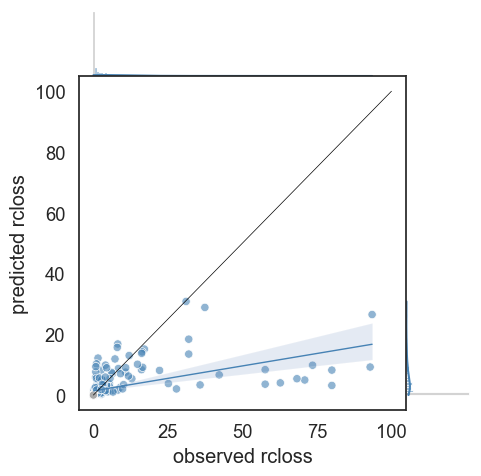

In [38]:
f.plot_observed_predicted(
    y_true=df_hcmc_pred_cd["rcloss"], y_pred=df_hcmc_pred_cd["pred_rcloss"], 
    # hue=df_hcmc_pred_cd["pred_rcloss_binary"], # pred chance of loss - binary
    hue=df_hcmc_pred_cd["obs_rcloss_binary"], 
    xlabel=f"observed rcloss", ylabel=f"predicted rcloss",  #  target="degree of rcloss",
    legend=False ,#True
    outfile= OUTPATH_BN + f"./scatter_obs_pred_rcloss_hcmc.png"
)     


### Main validation results

In [39]:
# ## get damage ratio in respect to total number of cases
# c = "y_pred"
# print(len(np.where(rcloss_pred > 0.0)[0])) 
# print(len(np.where(rcloss_pred > 0.0)[0]) / len(rcloss_true) * 100, "%")
# np.mean(rcloss_true)

## get ratio of damage cases vs total reported bred
c = df_hcmc_pred_cd["rcloss"]
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


113
39.37282229965157 %


5.0030088025434285

In [40]:
residuals_hcmc = pd.DataFrame(
            {
                "y_true": df_hcmc_pred_cd["rcloss"],
                "y_pred":  df_hcmc_pred_cd["pred_rcloss"],
                "residual": df_hcmc_pred_cd["pred_rcloss"] - df_hcmc_pred_cd["rcloss"],
            },
            index=df_hcmc_pred_cd["rcloss"].index,
        )
print(residuals_hcmc.describe())


for c in residuals_hcmc.columns:
    ci = eu.calc_confidence_interval(residuals_hcmc[c], confidence_level=0.95)

eu.empirical_vs_predicted(df_hcmc_pred_cd["rcloss"], df_hcmc_pred_cd["pred_rcloss"])

           y_true      y_pred    residual
count  287.000000  287.000000  287.000000
mean     5.003009    2.218017   -2.784992
std     14.678248    4.429032   12.824431
min      0.000000    0.000000  -83.622421
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      2.131646    2.838400    0.000000
max     93.505318   30.817320   10.624117
confidence interval: (3.2976213195082735, 6.7083962855785835),
cases within interval: 21
confidence interval: (1.7034309048564995, 2.7326021961887963),
cases within interval: 13
confidence interval: (-4.274994626287955, -1.294989877753604),
cases within interval: 16


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,287,0.0,4.808362,"[0, 93]",212.06,14.54,302.851467
predicted,287,0.0,2.031359,"[0, 30]",18.34,4.27,210.810087


In [41]:
import numpy as np, scipy.stats as st

confidence_level=0.95

for c in residuals_hcmc.columns:
    
    conf_interval = st.t.interval(0.95, len(residuals_hcmc[c])-1, loc=np.mean(residuals_hcmc[c]), scale=st.sem(residuals_hcmc[c]))
    counts = ((residuals_hcmc[c] > conf_interval[0]) & (residuals_hcmc[c] <= conf_interval[1])).sum(axis=0)
    print("confidence interval:", conf_interval, f"\ncases within interval: {counts}")



confidence interval: (3.2976213195082735, 6.7083962855785835) 
cases within interval: 21
confidence interval: (1.7034309048564995, 2.7326021961887963) 
cases within interval: 13
confidence interval: (-4.274994626287955, -1.294989877753604) 
cases within interval: 16


#### Plot residuals
Plot observation vs residuals

In [42]:
from matplotlib.colors import to_rgba

def plot_residuals_single(x, y, hue_group=None):

    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)

    hue_colors=("darkgrey","steelblue")
    alpha=0.7

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    ax.axhline(0, ls='--')
    sns.scatterplot(
        x = x, 
        y = y, # pred - obs 
        hue = hue_group,
        color = "steelblue",
        alpha = 0.5,
        #hue=df_hcmc_abred["abs_bred_true_dummy"]
        palette=color_dict, edgecolors=color_dict
    )
    plt.xlabel("observation")
    plt.ylabel("residuals (prediction - observation)")


**test residuals grouped by sales / sector**

In [43]:
df_hcmc_pred_cd.describe()
# 
df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth"] < 30, :]

,rcloss,mthly. sales,building age,mthly. income,flow velocity,water depth inside,non-structural measures,inundation duration,flood experience,no. employees,resilience,contaminations,emergency measures,building area,structural measures,chance of rcloss,pred_chance of rcloss,pred_chance of rcloss_binary,pred_degree of rcloss,degree,degree_pred,pred_rcloss,pred_rcloss_binary,obs_rcloss_binary
0,0.000000,276.2,12.0,110.5,0.2,10,0.00,2.0,76,1,5.00,0,0.000000,25.0,0.0,0.0,0.417,0,0.00,NaN,NaN,0.00000,0.0,0.0
1,0.000000,276.2,0.0,294.6,0.2,15,0.00,2.0,76,1,5.00,1,0.000000,21.0,0.0,0.0,0.501,1,0.00,NaN,NaN,0.00000,0.0,0.0
2,0.000000,92.1,21.0,552.4,0.2,2,0.75,1.0,76,1,3.50,0,0.000000,50.0,0.5,0.0,0.153,0,0.00,NaN,NaN,0.00000,0.0,0.0
3,0.000000,92.1,20.0,110.5,0.1,10,0.75,3.0,16,1,4.00,0,0.000000,25.0,0.0,0.0,0.175,0,0.00,NaN,NaN,0.00000,0.0,0.0
4,0.000000,92.1,20.0,294.6,0.3,5,0.25,3.0,16,1,4.00,1,0.000000,80.0,0.5,0.0,0.326,0,0.00,NaN,NaN,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,4.799922,92.1,56.0,294.6,0.4,15,0.25,3.0,151,1,2.25,2,0.833333,56.0,0.0,1.0,0.448,0,2.42,4.80,2.42,1.08416,1.0,1.0
298,6.576147,92.1,14.0,920.6,0.2,10,0.25,2.0,151,1,2.00,1,0.500000,48.0,0.0,1.0,0.234,0,4.26,6.58,4.26,0.99684,1.0,1.0
300,0.000000,276.2,18.0,920.6,0.2,15,0.00,3.0,76,6,1.00,1,0.000000,96.0,0.5,0.0,0.125,0,0.00,NaN,NaN,0.00000,0.0,0.0
303,0.000000,92.1,14.0,110.5,0.1,10,0.75,0.5,76,1,2.25,0,0.000000,70.0,0.5,0.0,0.090,0,0.00,NaN,NaN,0.00000,0.0,0.0


(287, 3)
(226, 25)


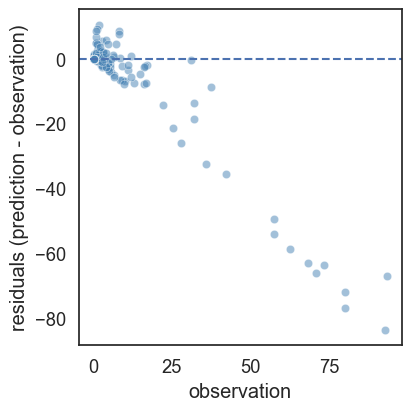

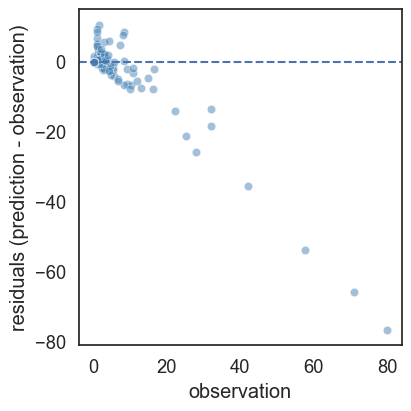

In [44]:
print(residuals_hcmc.shape)
plot_residuals_single(residuals_hcmc["y_true"], residuals_hcmc["residual"])

residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["mthly. sales"] < 300, :]
# residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth"] > 30, :]
#residuals_hcmc_subset = df_hcmc_pred_cd.loc[df_hcmc_pred_cd["water depth"] < 30, :]
residuals_hcmc_subset["residual"] = df_hcmc_pred_cd["pred_rcloss"] - df_hcmc_pred_cd["rcloss"]
print(residuals_hcmc_subset.shape)
plot_residuals_single(residuals_hcmc_subset["rcloss"], residuals_hcmc_subset["residual"])

## tested groups
## --> wd: when wd > 30m and sm losses occured than they are rather predictedoverestiated by the model (compared to residuals based on all samples)
##      wd < 30 and small losses are predicted with small bias
## --> sales: the flood cases with middle and higher sales are quite well predicted as long as their losses are under 25%, 
## lower sales even with lower loss ratios have relatively higher prediction bias

Text(0, 0.5, 'residuals (prediction - observation)')

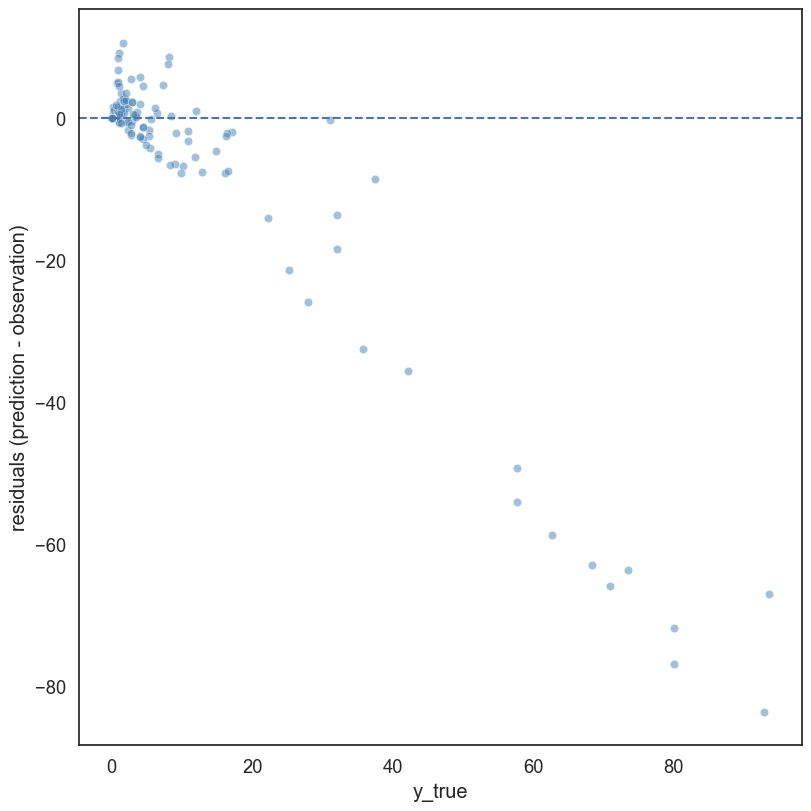

In [45]:
residuals_hcmc.describe()

from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x=residuals_hcmc.y_true, 
    y=residuals_hcmc.residual,
    color="steelblue", alpha=0.5
    #hue=df_hcmc_adegree["abs_degree_true_dummy"]
    #palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")


#### Model - observations

In [46]:
# # plot_boxplot_scatterplot(df_hcmc_adegree, group, column, scatterpoints)
# # df_hcmc_acloss["diff_pred_vs_obs"] = df_hcmc_acloss[pred_target_degree] - df_hcmc_acloss[target_degree]
# df_hcmc_acloss["diff_pred_vs_obs"] = df_hcmc_acloss[pred_target_degree] - df_hcmc_acloss[target_degree]
# sns.boxplot(x=df_hcmc_acloss["diff_pred_vs_obs"] )

# # sns.boxplot(
# #    # x=df_hcmc_pred_cd[target_degree][df_hcmc_pred_cd[target_degree]>0.0]
# #    x=df_hcmc_pred_cd[pred_target_degree][df_hcmc_pred_cd[pred_target_degree]>0.0]
# # )



# Model transferability
Test trained NPBN for CanTHo DS

In [47]:
## load cantho predictors
infile_name = "input_data_contentloss_cantho"
df_cantho_incl_zero = pd.read_excel(f"{INPATH_DATA}/{infile_name}.xlsx")

##  use nice feature names
df_cantho_incl_zero.rename(columns=s.feature_names_plot, inplace=True) 

print(df_cantho_incl_zero[target_rcloss].describe())

## load classifier for chance of loss
# clf_file = "LogisticRegression_target_relative_contentloss_euro"
clf_file = "LogisticRegression_chance of rcloss"
clf_filepath = OUTPATH_FINALMODELS + f"./{clf_file}.joblib"
clf = load(clf_filepath) 
clf


count    313.000000
mean       9.656027
std       17.935054
min        0.000000
25%        0.000000
50%        0.000000
75%       10.612845
max       92.950717
Name: rcloss, dtype: float64


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=9, l1_ratio=0.75, max_iter=500,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [48]:
# LogReg or RF cant predict on incomplete records
#pp.percentage_of_nan(df_cantho_incl_zero)
# df_cantho_incl_zero = df_cantho_incl_zero.dropna() 
df_hcmc_incl_zero.dropna()

,rcloss,mthly. sales,building age,mthly. income,flow velocity,water depth inside,non-structural measures,inundation duration,flood experience,no. employees,resilience,contaminations,emergency measures,building area,structural measures
0,0.0,276.2,12.0,110.5,0.2,10,0.00,2.0,76,1,5.00,0,0.000000,25.0,0.0
1,0.0,276.2,0.0,294.6,0.2,15,0.00,2.0,76,1,5.00,1,0.000000,21.0,0.0
2,0.0,92.1,21.0,552.4,0.2,2,0.75,1.0,76,1,3.50,0,0.000000,50.0,0.5
3,0.0,92.1,20.0,110.5,0.1,10,0.75,3.0,16,1,4.00,0,0.000000,25.0,0.0
4,0.0,92.1,20.0,294.6,0.3,5,0.25,3.0,16,1,4.00,1,0.000000,80.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,276.2,2.0,552.4,0.4,50,1.00,5.0,151,2,1.50,1,1.000000,185.0,0.5
316,0.0,92.1,33.0,110.5,0.3,60,1.00,4.0,151,2,3.75,1,0.833333,150.0,0.0
317,0.0,92.1,15.0,110.5,0.3,40,0.75,2.0,76,1,3.25,1,0.666667,80.0,0.0
318,0.0,276.2,1.0,294.6,0.2,40,0.50,5.0,151,2,2.00,1,0.666667,80.0,0.0


In [49]:
## get same index for chance and degree df to multiply them later based on ther idx
df_cantho_incl_zero.dropna(inplace=True) # LogReg or RF cant predict on incomplete records
df_cantho_incl_zero = df_cantho_incl_zero.reset_index(drop=True)

## binary cases for chance of loss 
df_cantho_c = df_cantho_incl_zero.copy()
df_cantho_c[target_rcloss][df_cantho_c[target_rcloss] > 0] = 1 ## set target_degree as binary class
## rename of target
df_cantho_c.rename(columns={"rcloss": target_chance}, inplace=True)

## clean df from variables only needed to calc abs. loss
df_cantho_c.drop(
    ["closs",
     "shp_sector",
     "shp_content_value_euro", # drop content value due only needed for abs. los calcualtion
     ], axis=1, inplace=True
)
# df_cantho_c = df_cantho_c.dropna() # LogReg or RF cant predict on incomplete records
## chance of loss: predictors and target_degree
df_cantho_c_X = df_cantho_c.drop(target_chance, axis=1)
df_cantho_c_y = df_cantho_c[target_chance]
print("Cases to predict chance of loss:", df_cantho_c_X.shape[0])



## damage cases of CanTHo used to predict on
df_cantho_d = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rcloss]>0.0, :]  # extract damage cases (loss >0.0)
## rename of target
df_cantho_d.rename(columns={"rcloss":"degree of rcloss"}, inplace=True)

## clean df from variables only needed to calc abs. loss
df_cantho_d.drop(
    ["closs",
     "shp_sector",
     "shp_content_value_euro", # drop content value due only needed for abs. los calcualtion
     ], axis=1, inplace=True
)
# df_cantho_d = df_cantho_d.dropna()  # LogReg or RF cant predict on incomplete records
## degree of loss: predictors and target_degree
df_cantho_d_X = df_cantho_d.drop(target_degree, axis=1)
df_cantho_d_y = df_cantho_d[target_degree]
print("Damage cases to predict degree of loss:", df_cantho_d_X.shape[0])

Cases to predict chance of loss: 266
Damage cases to predict degree of loss: 132


In [50]:
## df_cantho_incl_zero is later used as template df for rel + abs. loss, therefore it needs same index for damamge cases as predicted degree from BN
assert all(df_cantho_d[target_degree].index  == df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rcloss]> 0.0, target_rcloss].index)  ==True, 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

## chance and degree will be used to calc rel and abs closs therefore both need to keep index sturucture as 
assert all(df_cantho_d[target_degree].index == df_cantho_c.loc[df_cantho_c[target_chance]>0.0, target_chance].index), 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

In [51]:
# ## high sale rates
# print(df_cantho_incl_zero.mthly. sales.describe())
# df_cantho_incl_zero.loc[df_cantho_incl_zero.mthly. sales > 2500, :]

# ## -> high sale rates are not an indication for a larger building area or many employees

In [52]:
df_cantho_d.describe()

,degree of rcloss,inundation duration,water depth,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,19.569181,3.833333,25.712121,0.712121,0.365152,44.689394,29.469697,93.414394,266.599242,0.304714,1.606061,0.325758,0.247475,2.795455,628.966667
std,21.490749,2.904108,16.158344,0.470995,0.104833,33.285976,14.790362,180.419224,292.537394,0.193486,1.124044,0.247004,0.208477,1.590711,2385.354912
min,0.149707,1.000000,3.000000,0.000000,0.100000,3.000000,8.000000,9.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,12.800000
25%,3.736233,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,42.375000,149.600000,0.111111,1.000000,0.250000,0.000000,1.000000,85.600000
50%,10.631700,3.000000,20.000000,1.000000,0.400000,76.000000,26.000000,70.000000,149.600000,0.333333,1.000000,0.250000,0.333333,3.000000,171.000000
75%,27.888134,5.000000,36.250000,1.000000,0.400000,76.000000,36.000000,100.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,384.700000
max,92.950717,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,2137.500000,0.777778,7.000000,1.000000,0.666667,6.000000,25650.200000


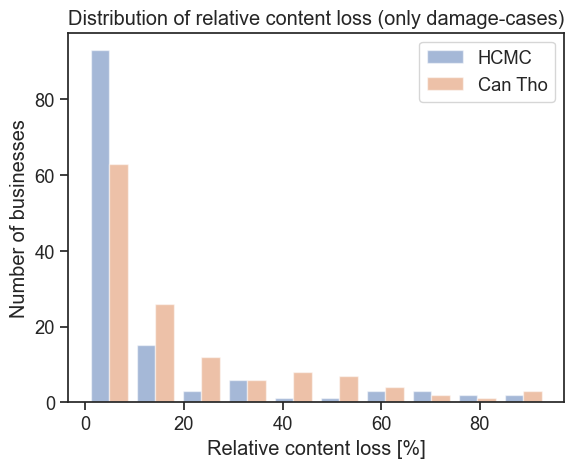

In [53]:
sns.set_style(style="ticks")
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn[target_degree], 
        df_cantho_d[target_degree]
    ], 
    #color=["r","b"], 
    alpha=0.5,  
    label=["HCMC", "Can Tho"],
    bins=10, #np.linspace(0, 101, 10)
)  ## TODO make bins in decimal steps, probably no ibs or prds between 70-80 -> thats why bins are not in dcimal steps

# plt.xticks(np.arange(0, 100, 10)),
plt.xlabel("Relative content loss [%]")
plt.ylabel("Number of businesses")
plt.legend(loc="upper right")
plt.title("Distribution of relative content loss (only damage-cases)")# (source: survey datasets)
plt.show()

#     bins=10 #np.linspace(0, 101, 10)
# )
# plt.xticks(np.arange(0, 100, 10)),

#  df_hcmc_pred_cd # rel rcloss


### predict chance of loss - CanTho

In [54]:
## predict chance of loss for CanTho
print("predicting chance of loss for CanTho")
y_cantho_c_pred_proba = clf.predict_proba(df_cantho_c_X)  # probabilitiies and predicted class

y_cantho_c_pred = np.argmax(y_cantho_c_pred_proba, axis=1)
y_cantho_c_proba = np.take_along_axis(
    y_cantho_c_pred_proba, 
    np.expand_dims(y_cantho_c_pred, axis=1), 
    axis=1
)
## store results in df
df_cantho_c[pred_target_chance] = y_cantho_c_proba
df_cantho_c[pred_target_chance + "_binary"] = y_cantho_c_pred.astype(float)

# y_cantho_proba = pd.DataFrame(y_cantho_c_proba)#.flatten()
# print(y_cantho_c_proba, y_cantho_c_pred)

##  update probability column in respect to y_pred, 
## currently zero-loss cases have also probability between 0.5 - 1.0 % --> should be 0.0 - 0.49 %: if ypred == 0 --> then proba should be 1.0 -> 0.0 ; 0.98 -> 0.02  [old proba -> new proba]
df_cantho_c = eu.reverse_probability_scores(df_cantho_c, pred_target_chance, (pred_target_chance+"_binary", 0.0))
df_cantho_c

print(f"Actual zero-loss: {len(np.where(df_cantho_c[target_chance] == 0)[0])}, \nActual damage: {df_cantho_c.loc[df_cantho_c[target_chance] == 1.0, : ].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_cantho_c[pred_target_chance + '_binary'] == 0)[0])}, \nPredict as damage: {len(np.where(df_cantho_c[pred_target_chance +'_binary'] == 1)[0])} ")




predicting chance of loss for CanTho
Actual zero-loss: 134, 
Actual damage: 132 

Predict as zero-loss: 246, 
Predict as damage: 20 


#### Plot predicted probability distrbution of chance of rcloss

In [55]:
# df_hcmc_pred_cd
df_hcmc_c.describe()

df_cantho_c

,chance of rcloss,inundation duration,water depth,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales,pred_chance of rcloss,pred_chance of rcloss_binary
0,0.0,3.0,40,1,0.4,76,16.0,60.0,149.6,0.444444,1,0.00,0.000000,5,855.0,0.0,0.0
1,1.0,3.0,30,1,0.5,76,26.0,31.5,320.6,0.444444,3,0.25,0.333333,1,641.3,0.0,0.0
2,0.0,3.0,20,1,0.4,76,16.0,20.0,320.6,0.444444,1,0.50,0.333333,5,641.3,0.0,0.0
3,0.0,4.0,40,1,0.3,76,16.0,49.0,149.6,0.222222,2,0.50,0.000000,4,128.3,0.0,0.0
4,1.0,1.0,20,0,0.3,8,8.0,100.0,320.6,0.222222,1,0.75,0.333333,1,64.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1.0,3.0,50,0,0.1,76,36.0,30.0,149.6,0.111111,1,0.00,0.000000,2,171.0,0.0,0.0
262,0.0,5.0,60,0,0.1,8,26.0,140.0,320.6,0.555556,1,0.50,0.333333,2,299.3,0.0,0.0
263,0.0,2.0,20,1,0.3,8,16.0,184.0,149.6,0.444444,1,0.50,0.333333,3,85.6,0.0,0.0
264,1.0,3.0,20,1,0.3,8,26.0,150.0,320.6,0.444444,4,0.50,0.666667,1,1710.0,0.0,0.0


In [56]:

## add chance of loss as column to results df
df_cantho_c[pred_target_chance]= 0.0 ## NOTE keep as 0.0 to join with floats of y_pred, otherwise multiplcation with degree of rcloss does not work
# df_cantho_c[f"{pred_target_chance}_binary"]= pred_chance of rcloss_binar 
df_cantho_c[pred_target_chance][:] =  df_cantho_c[pred_target_chance][:]  # pred. probas of chance,  join by neglecting different indices
df_cantho_c[f"{pred_target_chance}_binary"][:] =  df_cantho_c[f"{pred_target_chance}_binary"][:]  # pred. single values [0,1] of chance,  join by neglecting different indices
#df_hcmc_pred_cd[f"predicted chance of closs"]
df_cantho_c.describe()#[f"chance_pred_proba"]

,chance of rcloss,inundation duration,water depth,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales,pred_chance of rcloss,pred_chance of rcloss_binary
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.0,266.000000
mean,0.496241,4.212406,26.214286,0.714286,0.361278,42.849624,28.808271,96.605639,262.266541,0.300334,1.639098,0.296053,0.233083,2.763158,487.436842,0.0,0.075188
std,0.500928,3.177010,15.604642,0.476963,0.110763,33.399468,14.565561,177.343788,273.542113,0.192031,1.196462,0.252335,0.206742,1.627684,1749.684023,0.0,0.264191
min,0.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,12.800000,0.0,0.000000
25%,0.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.250000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,85.600000,0.0,0.000000
50%,0.000000,3.000000,20.000000,1.000000,0.400000,36.000000,26.000000,64.500000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,171.000000,0.0,0.000000
75%,1.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,384.700000,0.0,0.000000
max,1.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,25650.200000,0.0,1.000000


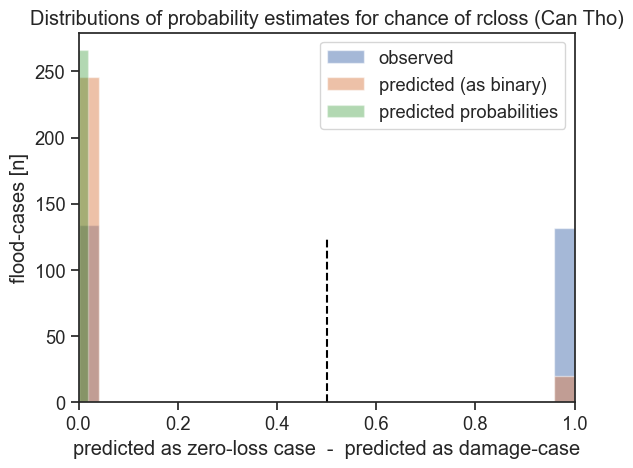

In [57]:


bins = np.linspace(0, 1, 25)
plt.hist( df_cantho_c["chance of rcloss"], bins, alpha=0.5, label="observed")
plt.hist(df_cantho_c[f"{pred_target_chance}_binary"], bins, alpha=0.5, label="predicted (as binary)")
plt.hist( df_cantho_c[pred_target_chance], 25, alpha=0.3, label="predicted probabilities", color="green")
plt.legend(loc="upper right")
plt.title("Distributions of probability estimates for chance of rcloss (Can Tho)")
plt.xlim(0,1)
plt.ylabel("flood-cases [n]")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")

plt.xlabel("predicted as zero-loss case  -  predicted as damage-case")
plt.show()


**Note** : Logisitc Regression preidcted all cases in Can THo wiht high certainty as zero-loss, thus the entire ensmeble of LR and BN can not be validated for the transfer region. In detail, the BN model (degree of loss) is applicable for Can THo but not the LR (chance of loss)

### predict degree of loss - CanTho

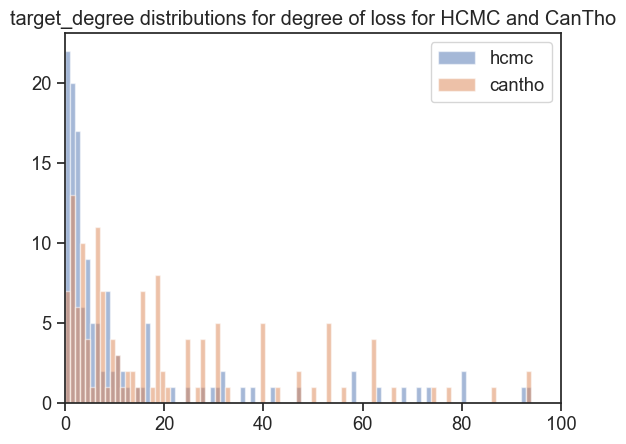

In [118]:
bins = np.linspace(0, 100, 100)

plt.hist(df_hcmc_bn[target_degree], bins, alpha=0.5, label="hcmc")
plt.hist(df_cantho_d[target_degree], bins, alpha=0.5, label="cantho")
plt.legend(loc="upper right")
plt.title("target_degree distributions for degree of loss for HCMC and CanTho")
plt.xlim(0,100)
plt.show()


In [119]:
condition = condition #[1, 2, 3, 4 ]

df_cantho_d = df_cantho_d[df_hcmc_bn.columns] # give cantho DF same column order as for HCMC ds, DF inlcudes only predicted damage cases

values = df_cantho_d.iloc[:,condition].to_numpy() # data for conditionalization
# values = df_cantho_bn[df_hcmc_bn.columns].to_numpy() # data for conditionalization, only X, same variables as for BN contructed on HCMC

bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}


# BN build rank correlations from all damage-cases in HCMC dataset
R = bn_rankcorr(parent_cell,        # structure of the BN
    df_hcmc_bn,   # matrix of df_hcmc
    var_names = names,  # names of variables
    is_data = True,        # matrix data contains actual data
    plot = False) 

## make inference for BN transfered to Can Tho, predict degree of loss for Can THo 
F = inference(condition,        # nodes that will be conditionalized
        values,           # information used to conditionalize the nodes of the NPBN
        R,                # the rank correlation matrix from BN constructed for damage-cases in HCMC 
        df_cantho_d,     # unseen ds from CanTHo only with damage cases, same predictors as used to train the BN for HCMC
        SampleSize=1000, Interp='next',
        Output="mean")    # type of output data
              #Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target_degree and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_d.loc[:,target_degree].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

## evaluate against test_nth_fold
bn_scores["MAE"].append(MAE)
bn_scores["MBE"].append(MBE)
bn_scores["RMSE"].append(RMSE)
bn_scores["SMAPE"].append(SMAPE)


print("Prediction performance for the degree of loss (Can Tho):" )  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

eu.empirical_vs_predicted(y_true, y_pred)

KeyError: "['water depth inside'] not in index"

In [ ]:
pred_d_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residuals": pd.Series(y_pred) - pd.Series(y_true),
            },
            index=pd.Series(y_true).index,
        )
print(pred_d_cantho.describe())

# for c in pred_d_cantho.columns:
#     ci = eu.calc_confidence_interval(pred_d_cantho[c], 0.95)


           y_true      y_pred   residuals
count  132.000000  132.000000  132.000000
mean    19.569181   15.669566   -3.899615
std     21.490749    7.832215   23.043030
min      0.149707    2.967408  -86.417238
25%      3.736233    9.828316  -10.929246
50%     10.631700   14.001420    3.971770
75%     27.888134   20.933216   10.462246
max     92.950717   38.142732   30.061119


In [ ]:
# bins = np.linspace(0, 100, 100)

# plt.hist((pd.Series(pred_d_cantho.y_true.astype(int))), bins, alpha=0.5, label="empirical")
# plt.hist((pd.Series(pred_d_cantho.y_pred.astype(int))), bins, alpha=0.5, label="predicted")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for CanTho (empirical and predicted)")
# plt.show()


Condtionalize with missing predictor for non-structural measures [node 5], make inference of non-structural measures and target variable, condtionalize on the  remaining predictors

In [ ]:
# condition = [1, 2, 3, 4] #condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_d.iloc[:, [1, 2, 3, 4]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_d,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([1, 2, 3, 4],        # nodes that will be conditionalized - sparse model
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d, #df_cantho_bn.drop("water depth", axis=1),        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data
              #Output="median")    # type of output data

## inference of node for water depth and node for target
F_nonstruct = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_d.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, pd.Series(y_pred))

Inference - Uncertainty distribution:  count    132.000000
mean       0.321973
std        0.044879
min        0.217400
25%        0.291950
50%        0.322425
75%        0.351175
max        0.433300
dtype: float64
MAE,: 19.25063594713894
MAE, MBE, RMSE, SMAPE: 19.25063594713894 -19.24720801787373 28.787016326344826 86.9212619623069

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,132,10.0,19.045455,"[0, 92]",460.18,21.37,112.634921
predicted,132,0.0,0.000000,"[0, 0]",0.00,0.00,NaN


In [ ]:
residuals_cantho_sparse = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho_sparse.reset_index(drop=True, inplace=True)
residuals_cantho_sparse["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho_sparse["y_true"] >= 1)[0]
residuals_cantho_sparse.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho_sparse.describe()


print("Degree of rcloss, cantho, sparse BN")
print(residuals_cantho_sparse.describe())



Degree of rcloss, cantho, sparse BN
           y_true      y_pred    residual  binary_true_dummy
count  132.000000  132.000000  132.000000         132.000000
mean    19.569181    0.321973  -19.247208           0.946970
std     21.490749    0.044879   21.488027           0.224948
min      0.149707    0.217400  -92.600717           0.000000
25%      3.736233    0.291950  -27.582127           1.000000
50%     10.631700    0.322425  -10.284275           1.000000
75%     27.888134    0.351175   -3.419754           1.000000
max     92.950717    0.433300    0.226243           1.000000


### CDFs of predictions of degree of rcloss
Cumulative error of predictions for HCMC and Can THo

In [ ]:
residuals_hcmc

,y_true,y_pred,residual
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
312,0.0,0.0,0.0
313,0.0,0.0,0.0
314,0.0,0.0,0.0
315,0.0,0.0,0.0


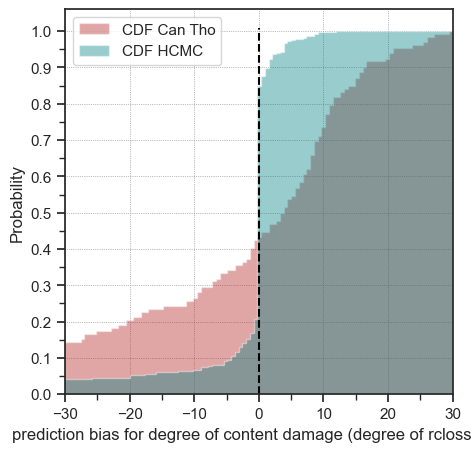

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [residuals_hcmc["residual"], pred_d_cantho["residuals"]],#, residuals_cantho_sparse["residual"]],  # pred HCMC+CanTHo rbred
    #[residuals_hcmc["residual"], pred_d_cantho["residuals"], residuals_cantho_sparse["residual"]],  # pred HCMC+CanTHo rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
   histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    # color=("teal","firebrick", "indianred"), 
    label=( "CDF HCMC", "CDF Can Tho",  "CDF Can Tho - sparse"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


# ## plt.xticks(np.arange(-80, 50, 10))
# plt.xlim(-100, 40)
# plt.xticks(np.arange(-100, 41, 20), minor=False)
# plt.xticks(np.arange(-100, 41, 10), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-30, 30, facecolor='grey', alpha=0.3)


## zoomed in
plt.xlim(-30, 30)
plt.xticks(np.arange(-30, 31, 10))
plt.xticks(np.arange(-30, 31, 5), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for degree of content damage (degree of rcloss) [%]")
plt.ylabel("Probability")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")

# plt.title("Cumulative distribution functions (CDFs) of prediction bias, normalized")
# plt.savefig(OUTPATH_BN + f"./cdf_{pred_target_degree}.png", dpi=300, bbox_inches="tight")

plt.savefig(OUTPATH_BN + f"./cdf_zoomed_{pred_target_degree}.png", dpi=300, bbox_inches="tight")




### Uncertainties in degree of rcloss predictions

In [ ]:
condition = condition # [1, 2, 3, 4] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_d.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_d.iloc[:,0].to_numpy()


### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)


# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_p = pd.DataFrame()
df_uncertainties_c_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_p["observed"] = df_cantho_d["degree of rcloss"]
df_uncertainties_c_p["city"] = "Can Tho"


In [ ]:
## uncertainties for sparse BN  - make inference on mthly [node:2]. sales and target

values = df_cantho_d.iloc[:,[2, 3, 4, 5]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([2, 3, 4, 5],        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_d,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


## inference of node for water depth and node for target
F_water = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_d.iloc[:,0].to_numpy()


dict = {}
for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_sparse_p = pd.DataFrame()
df_uncertainties_c_sparse_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_sparse_p["observed"] = df_cantho_d["degree of rcloss"].reset_index(drop=True)
df_uncertainties_c_sparse_p["city"] = "Can Tho - sparse"
df_uncertainties_c_sparse_p

Inference - Uncertainty distribution:  count                                                   132
unique                                                  132
top       [20.0, 35.0, 3.0, 10.0, 10.0, 20.0, 10.0, 15.0...
freq                                                      1
dtype: object


,avg_modelled,observed,city
0,23.8269,0.662986,Can Tho - sparse
1,22.9212,0.149707,Can Tho - sparse
2,22.9917,4.341588,Can Tho - sparse
3,20.9294,9.294347,Can Tho - sparse
4,22.5614,3.281143,Can Tho - sparse
...,...,...,...
127,26.3752,3.094005,Can Tho - sparse
128,26.3700,10.623822,Can Tho - sparse
129,26.6423,53.117690,Can Tho - sparse
130,26.6522,6.200487,Can Tho - sparse


In [ ]:
## join uncertainites from BNs for hcmc, cantho, and cantho-sparse 

df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p], axis=0)
# df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p, df_uncertainties_c_sparse_p], axis=0)
df_uncertainties_hc_sparse_p
# df_uncertainties_hc_p = pd.melt(df_uncertainties_hc_p, id_vars=['city'], var_name=['city'])
print(df_uncertainties_hc_sparse_p)


     avg_modelled   observed     city
0       11.870968   0.920782     HCMC
1        1.880111   0.805886     HCMC
2        2.932630   0.805886     HCMC
3       34.649534  73.531408     HCMC
4       10.880495   0.799444     HCMC
..            ...        ...      ...
127     12.707225   1.336630  Can Tho
128      5.691546   8.059385  Can Tho
129     21.834180   9.294347  Can Tho
130     29.474669        NaN  Can Tho
131     14.313939   0.668315  Can Tho

[258 rows x 3 columns]


In [ ]:
df_uncertainties_hc_sparse_p.describe()

,avg_modelled,observed
count,258.000000,196.000000
mean,15.234882,15.089906
std,12.806466,21.019056
min,1.188771,0.149707
25%,7.752552,1.699115
50%,12.326271,5.637041
75%,19.844606,18.220591
max,91.772324,92.950717


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


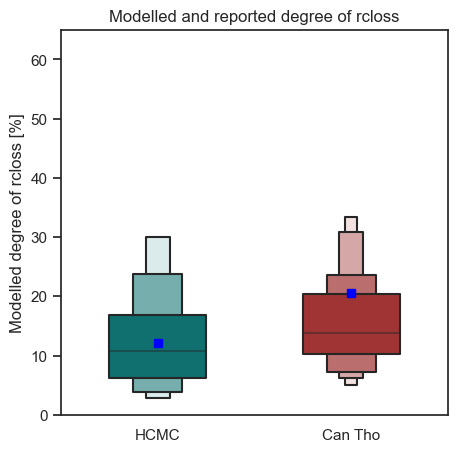

In [ ]:
group = "city"
column = "avg_modelled"
scatterpoints="observed"


grouped = df_uncertainties_hc_sparse_p.groupby(group)
categories = np.unique(df_uncertainties_hc_sparse_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))


names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())

# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(5, 5))
fig.canvas.draw()


## average predicted means
p = sns.boxenplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["avg_modelled"],
    width=.5,
    showfliers=False,
    # showmeans=True,
    palette=["teal", "firebrick"],
    # palette=["teal", "firebrick", "lightcoral"],
    line_kws={"linewidth":1.5},# color":"cde"
    flier_kws={"facecolor":.7, "linewidth":.5},
)

# observed mean
sns.boxplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["observed"],
    # labels="HCMC",
    showfliers=False,
    showmeans=True,
    medianprops={"color": "r", "linewidth": 0, "alpha":0.0},
    boxprops={"facecolor":"steelblue", "alpha":0.0},
    whiskerprops={"color":"k", "alpha":0.},
    capprops={"color":"k", "alpha":0},
    # medianprops={"color": "blue", "markerfacecolor":"blue", "markeredgecolor":"blue"},
    meanprops={"marker":"s", "markerfacecolor":"blue", "markeredgecolor":"blue"}
)

p.tick_params(bottom=False)  # remove x ticks
# ax.get_legend().set_visible(False)
plt.legend().set_visible(False)  # surpress legend

plt.ylim(0, 65)
plt.ylabel(f"Modelled {target_degree} [%]")
plt.xlabel(f"")
plt.title("Modelled and reported degree of rcloss")

plt.savefig(OUTPATH_BN + f"./uncertainties_{target_degree}.png", dpi=300, bbox_inches="tight")


In [ ]:
df_hcmc_bn.describe()

,degree of rcloss,water depth inside,mthly. sales,building age,structural measures,non-structural measures
count,126.000000,126.000000,126.000000,122.000000,126.000000,126.000000
mean,12.064998,38.031746,325.890476,19.745902,0.202381,0.349206
std,19.907199,28.148730,276.457742,12.656662,0.276973,0.272175
min,0.179416,2.000000,92.100000,0.000000,0.000000,0.000000
25%,1.432871,20.000000,92.100000,12.000000,0.000000,0.250000
50%,3.807401,30.000000,276.200000,18.000000,0.000000,0.250000
75%,10.586663,50.000000,276.200000,24.000000,0.500000,0.500000
max,91.672324,150.000000,1473.000000,62.000000,1.000000,1.000000


In [ ]:
import folium
map = folium.Map(location=[106.6637,10.6878], default_zoom_start=15)


### relative content loss estimates (chance * degree of loss)

In [ ]:
assert all(df_cantho_d[target_degree].index == df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rcloss]> 0.0, target_rcloss].index) == True, 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '
# assert len(df_cantho_c.loc[df_cantho_c[target_degree]> 0.0, target_degree].index) == len(df_cantho_d[target_degree].index) , 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '

In [ ]:
## index of damage cases
idx_damage = np.where(df_cantho_c_y == 1)[0]

## new col incl osbervation and prediction of degree of loss, thus all non-damage cases are 0 
df_cantho_pred_cd = df_cantho_incl_zero
### obs
df_cantho_pred_cd[target_degree] = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rcloss]> 0.0, target_rcloss]
## preds
df_cantho_pred_cd[pred_target_degree] = 0.0 
df_cantho_pred_cd.loc[idx_damage, pred_target_degree] = y_pred  ## add predicted degree of loss to df
df_cantho_pred_cd.loc[idx_damage, "degree_pred"] = y_pred  # BN results for degree needed for abs. degree of loss

## new col incl osbervation and prediction of chance of loss,
df_cantho_pred_cd[target_chance] = df_cantho_c[target_chance]
df_cantho_pred_cd[pred_target_chance] =  df_cantho_c[pred_target_chance]
df_cantho_pred_cd[pred_target_chance+"_binary"] = df_cantho_c[pred_target_chance+"_binary"]
df_cantho_pred_cd.describe()

ValueError: Must have equal len keys and value when setting with an ndarray

In [ ]:
df_cantho_pred_cd[[pred_target_degree, "pred_chance of rcloss"]].describe()

,pred_degree of rcloss,pred_chance of rcloss
count,266.000000,266.000000
mean,7.743948,0.003857
std,9.542361,0.061317
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,13.773843,0.000000
max,36.275848,1.000000


In [ ]:
## index of damage cases
idx_damage = np.where( df_cantho_c[target_chance] == 1)[0]

## new col incl osbervation and prediction of degree of loss, thus all non-damage cases are 0 
df_cantho_pred_cd = df_cantho_incl_zero
### obs
df_cantho_pred_cd[target_degree] = df_cantho_incl_zero.loc[df_cantho_incl_zero[target_rcloss]> 0.0, target_rcloss]
## preds
pred_target_degree = f"pred_{target_degree}"
df_cantho_pred_cd[pred_target_degree] = 0.0 
df_cantho_pred_cd.loc[idx_damage, pred_target_degree] = y_pred  ## add predicted degree of loss to df
df_cantho_pred_cd.loc[idx_damage, "degree_pred"] = y_pred  # BN results for degree needed for abs. degree of loss


# assert df_cantho_d[target_degree].index.all() == df_cantho_pred_cd.loc[df_cantho_pred_cd[target_degree]>0.0, target_degree].index.all(), 'damage cases in df "chance of loss" need to have the same idx as the damagecases in df"degree of loss" '
# print(df_cantho_pred_cd[[target_degree, pred_target_degree]].describe())
# print(df_cantho_incl_zero[target_degree].describe())



## pred_d_cantho  # degree of damages
## y_cantho_proba # chance that instance is a damage-case

## get estimation of relative content loss
df_cantho_pred_cd[pred_target_rcloss] = np.nan
df_cantho_pred_cd[pred_target_rcloss] = df_cantho_pred_cd[pred_target_degree] * df_cantho_pred_cd[pred_target_chance] # y_cantho_c_proba.squeeze()
df_cantho_pred_cd[pred_target_rcloss].describe()


## add binary observation and prediction of chance of loss
df_cantho_pred_cd["observed chance of closs"] = 0.0
df_cantho_pred_cd.loc[idx_damage, "observed chance of closs"] = 1
df_cantho_pred_cd[f"{pred_target_chance}_binary"] = y_cantho_c_pred
## add porabilities of prediction of chance of rcloss
df_cantho_pred_cd[pred_target_chance] = y_cantho_c_proba

df_cantho_pred_cd[[target_rcloss, pred_target_rcloss, target_degree,"degree_pred", "observed chance of closs", pred_target_chance, f"{pred_target_chance}_binary"]].describe()

## NOTE that chance of loss was nearly always predicted with 0.99% or 100% probability of being zero

,rcloss,pred_rcloss,degree of rcloss,degree_pred,observed chance of closs,pred_chance of rcloss,pred_chance of rcloss_binary
count,266.000000,266.000000,132.000000,132.000000,266.000000,266.000000,266.000000
mean,9.711022,0.052336,19.569181,15.605229,0.496241,0.999902,0.003759
std,18.011273,0.847334,21.490749,7.783638,0.500928,0.001042,0.061314
min,0.000000,0.000000,0.149707,3.078262,0.000000,0.986410,0.000000
25%,0.000000,0.000000,3.736233,10.065335,0.000000,1.000000,0.000000
50%,0.000000,0.000000,10.631700,13.843914,0.000000,1.000000,0.000000
75%,10.603385,0.000000,27.888134,20.226377,1.000000,1.000000,0.000000
max,92.950717,13.819614,92.950717,36.275848,1.000000,1.000000,1.000000


## Evaluation of rcloss estimations -Can THo

In [ ]:
## get ratio of damage cases vs total reported bred

c = df_cantho_pred_cd[target_degree]
print(len(np.where(c > 0.0)[0])) 
print(len(np.where(c > 0.0)[0]) / len(c) * 100, "%")
np.mean(c)


132
49.62406015037594 %


19.569180745146458

In [ ]:
## TODO make less but more consistent var names ,eg replace rcloss_ture with respective column from df_cantho_pred_cd

rcloss_true = df_cantho_pred_cd[target_rcloss]
rcloss_pred = df_cantho_pred_cd[pred_target_rcloss]

# evaluation metrics
MAE = eu.mean_absolute_error(rcloss_true, rcloss_pred)
MBE = eu.mean_bias_error(rcloss_true, rcloss_pred)
RMSE = eu.root_mean_squared_error(rcloss_true, rcloss_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(rcloss_true, rcloss_pred)


print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  


#print("\n", 
eu.empirical_vs_predicted(rcloss_true, rcloss_pred)


MAE,: 9.672747666839886
MAE, MBE, RMSE, SMAPE: 9.672747666839886 -9.65868647250402 20.41973944222929 49.2182326669472


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,266,0.0,9.451128,"[0, 92]",318.51,17.81,188.831565
predicted,266,0.0,0.048872,"[0, 13]",0.64,0.80,1630.950643


In [ ]:
print("Rcloss, cantho")
print(df_cantho_pred_cd[[target_rcloss, pred_target_rcloss]].describe())

for c in df_cantho_pred_cd[[target_rcloss, pred_target_rcloss]].columns:
    ci = eu.calc_confidence_interval(df_cantho_pred_cd[c], 0.95)


Rcloss, cantho
           rcloss  pred_rcloss
count  266.000000   266.000000
mean     9.711022     0.052336
std     18.011273     0.847334
min      0.000000     0.000000
25%      0.000000     0.000000
50%      0.000000     0.000000
75%     10.603385     0.000000
max     92.950717    13.819614
confidence interval: (7.536620942118491, 11.88542310569604) 
cases within interval: 14
confidence interval: (-0.04995842223305451, 0.1546295250395477) 
cases within interval: 265


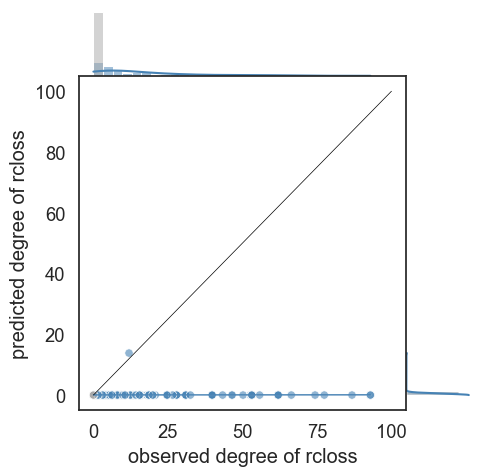

In [ ]:
f.plot_observed_predicted(
    df_cantho_pred_cd[target_rcloss], df_cantho_pred_cd[pred_target_rcloss],  
    hue = df_cantho_pred_cd["observed chance of closs"],
    #hue=df_cantho_pred_cd[f"{pred_target_chance}_binary"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}", #target=target_plot,
    legend=False, #True
    outfile=OUTPATH_BN + f"./scatter_obs_pred_{target_plot}_cantho.png"
)       

## NOTE the singe lgrey dot means: that nearly all chance of loss cases were predicted as zero-losses

In [ ]:
# bins = np.linspace(0, 100, 100)
# plt.hist(df_hcmc_bn[target_degree], bins, alpha=0.5, label="hcmc rcloss")
# plt.hist(df_cantho[target_degree], bins, alpha=0.5, label="cantho rcloss")
# plt.legend(loc="upper right")
# plt.title("target_degree distributions for both cities (empirical)")
# plt.show()


### Main validation results

Compare with Chinh 2016 for ChanTho closs:
aveg. content loss:


#### Plot residuals

In [ ]:
df_cantho_pred_cd

,rcloss,closs,inundation duration,water depth inside,contaminations,flow velocity,flood experience,building age,building area,emergency measures,mthly. income,non-structural measures,no. employees,structural measures,resilience,shp_content_value_euro,mthly. sales,degree of rcloss,pred_degree of rcloss,degree_pred,chance of rcloss,pred_chance of rcloss,pred_chance of rcloss_binary,pred_rcloss,observed chance of closs
0,0.000000,0.0,3.0,40,1,0.4,76,16.0,60.0,0.444444,149.6,0.00,1,0.000000,5,80.1625,855.0,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0
1,0.662986,24.8,3.0,30,1,0.5,76,26.0,31.5,0.444444,320.6,0.25,3,0.333333,1,3740.6500,641.3,0.662986,21.399714,21.399714,1.0,1.0,0,0.0,1.0
2,0.000000,0.0,3.0,20,1,0.4,76,16.0,20.0,0.444444,320.6,0.50,1,0.333333,5,40.0750,641.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0
3,0.000000,0.0,4.0,40,1,0.3,76,16.0,49.0,0.222222,149.6,0.50,2,0.000000,4,801.5500,128.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0
4,0.149707,6.0,1.0,20,0,0.3,8,8.0,100.0,0.222222,320.6,0.75,1,0.333333,1,4007.8375,64.1,0.149707,12.636456,12.636456,1.0,1.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,6.200487,49.7,3.0,50,0,0.1,76,36.0,30.0,0.111111,149.6,0.00,1,0.000000,2,801.5500,171.0,6.200487,29.720701,29.720701,1.0,1.0,0,0.0,1.0
262,0.000000,0.0,5.0,60,0,0.1,8,26.0,140.0,0.555556,320.6,0.50,1,0.333333,2,1603.1250,299.3,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0
263,0.000000,0.0,2.0,20,1,0.3,8,16.0,184.0,0.444444,149.6,0.50,1,0.333333,3,374.0750,85.6,NaN,0.000000,NaN,0.0,1.0,0,0.0,0.0
264,1.546979,24.8,3.0,20,1,0.3,8,26.0,150.0,0.444444,320.6,0.50,4,0.666667,1,1603.1250,1710.0,1.546979,15.087171,15.087171,1.0,1.0,0,0.0,1.0


Text(0, 0.5, 'residuals (prediction - observation)')

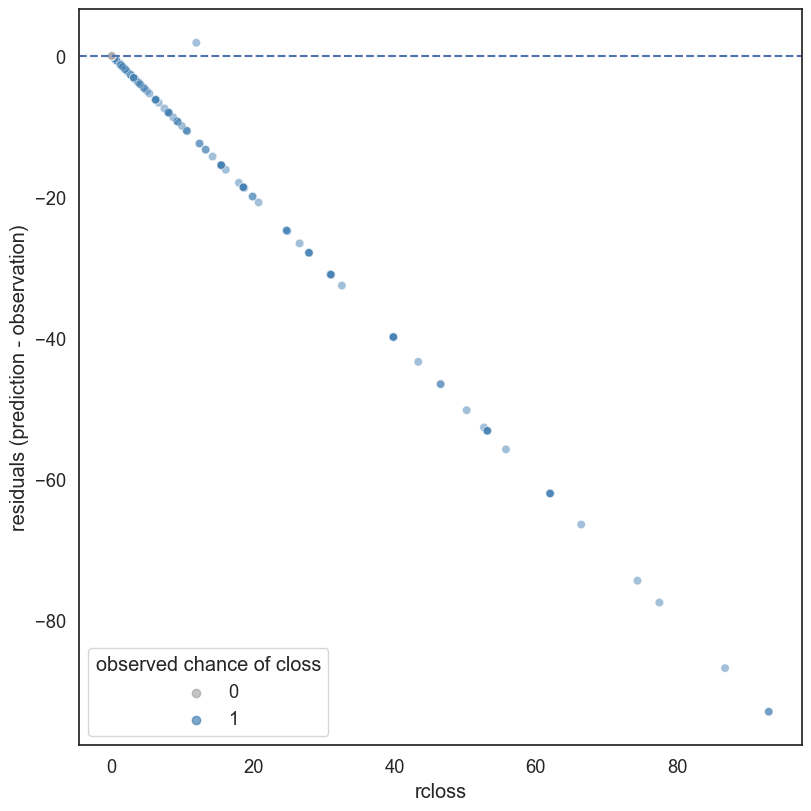

In [ ]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0.0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1.0: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = df_cantho_pred_cd[target_rcloss], 
    y = df_cantho_pred_cd[pred_target_rcloss] - df_cantho_pred_cd[target_rcloss], 
    hue = df_cantho_pred_cd["observed chance of closs"].astype(int),
    # hue = df_cantho_pred_cd[pred_target_chance+"_binary"].astype(int),  # NOTE all chance of loss cases were predicted as zero loss
    #color = "steelblue",
    alpha = 0.5,
    #hue=df_hcmc_adegree["abs_degree_true_dummy"]
    palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")



#### Plot predicted probabilities of transferred ML-estimator

In [ ]:
df_cantho_c_pred = df_cantho_pred_cd[f"{pred_target_chance}_binary"]
df_cantho_c_proba = df_cantho_pred_cd[pred_target_chance]
df_cantho_c_true = df_cantho_pred_cd["chance of rcloss"]

print(f"Actual zero-loss: {len(np.where(df_cantho_c_true == 0)[0])} \nActual damage: {df_cantho_c_true[df_cantho_c_true == 1.0].shape[0]} \n")
print(f"Predict as zero-loss: {len(np.where(df_cantho_c_pred == 0)[0])} \nPredict as damage: {len(np.where(df_cantho_c_pred == 1)[0])} ")


bins = np.linspace(0, 1, 25)
plt.hist(df_cantho_c_true, bins, alpha=0.3, label="observed", color="teal")
plt.hist(df_cantho_c_pred, bins, alpha=0.3, label="predicted (as binary)", color="firebrick", hatch="//")
plt.hist(df_cantho_c_proba, 25, alpha=0.3, label="predicted probabilities", color="maroon")
plt.legend(loc="upper right")
# plt.title("Distributions of probability estimates for chance of rcloss (HCMC)")
plt.xlim(0,1)
plt.xlabel("predicted as zero-loss case  -  predicted as damage-case")
plt.ylabel("flood-cases [n]")
plt.vlines(x=0.5, ymin=0, ymax=125, colors="black", linestyles="--")
plt.show()

plt.savefig(OUTPATH_BN + "histo_LR_proba_estimates.png", dpi=300, bbox_inches="tight")




NameError: name 'df_cantho_pred_cd' is not defined

### Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

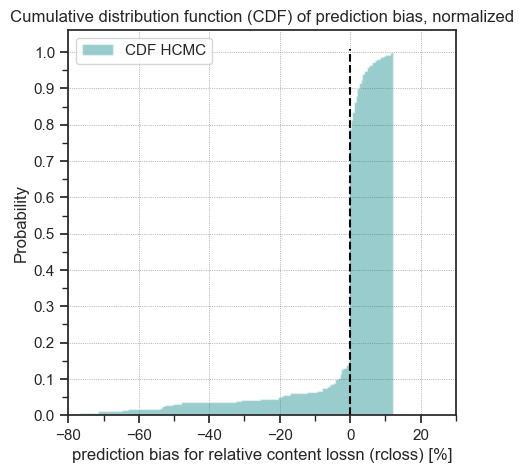

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    residuals_hcmc["residual"],
    # [residuals_hcmc["residual"], df_cantho_pred_cd[pred_target_rcloss] - df_cantho_pred_cd[target_rcloss]], # pred HCMC+CanTHo rbred
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    # color=("teal","firebrick"), 
    color=("teal"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


## plt.xticks(np.arange(-80, 50, 10))
plt.xlim(-80, 30)
plt.xticks(np.arange(-80, 31, 10), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-20, 20, facecolor='grey', alpha=0.3)

# ## zoomed in
# plt.xlim(-20, 20)
# plt.xticks(np.arange(-20, 21, 10))
# plt.xticks(np.arange(-20, 21, 5), minor=True)
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for relative content lossn (rcloss) [%]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction bias, normalized")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


plt.savefig(OUTPATH_BN + "cdf_rcloss.png", dpi=300, bbox_inches="tight")
# plt.savefig(OUTPATH_BN + "cdf_zoomed_closs.png", dpi=300, bbox_inches="tight")




# Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

In [ ]:
df_hcmc_c

,Unnamed: 0,y_true,y_pred,y_proba,residual,y_true_degree
0,0,0,0,0.459,0,0.0
1,1,0,1,0.517,-1,0.0
2,2,0,0,0.237,0,0.0
3,3,0,0,0.193,0,0.0
4,4,0,0,0.455,0,0.0
...,...,...,...,...,...,...
279,312,0,1,0.541,-1,0.0
280,313,0,1,0.613,-1,0.0
281,314,0,1,0.632,-1,0.0
282,315,0,1,0.515,-1,0.0


**Cumulative distribution function (CDF) of prediction errors**

In [ ]:
## creaate residuals of abs. pred.
df_hcmc_adegree["residual"] = df_hcmc_adegree["abs_degree_pred"] - df_hcmc_adegree["abs_degree_true"]
df_cantho_adegree["residual"] = df_cantho_adegree["abs_degree_pred"] - df_cantho_adegree["abs_degree_true"]


## create reisduals for rel. pred for  cantho
df_cantho_pred_cd["residual"] = df_cantho_pred_cd[pred_target_degree] - df_cantho_pred_cd[target_degree]

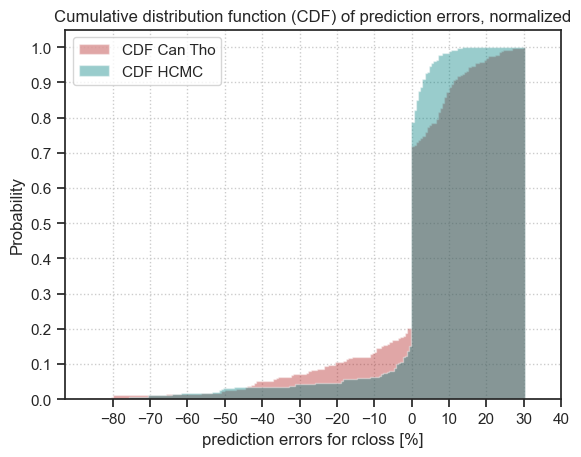

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : True,"grid.linestyle": ":"}
     )#"whitegrid", {"axes.grid" : False})
# style="ticks",


plt.hist(
    #[abs(residuals_hcmc["residual"]), abs(df_cantho_pred_cd["residual"])],   # pred. rel rcloss
    [residuals_hcmc["residual"], df_cantho_pred_cd["residual"]],   # pred. rel rcloss
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

plt.xticks(np.arange(-80, 50, 10))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xlabel("prediction errors for rcloss [%]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction errors, normalized")
plt.legend(loc='best')

# plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


plt.savefig(OUTPATH_BN + "cdf_rcloss.png", dpi=300, bbox_inches="tight")



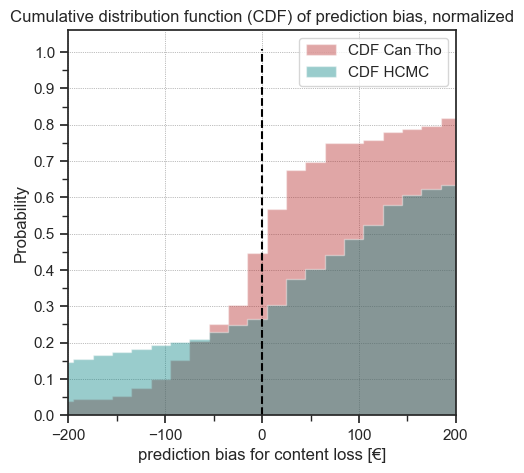

In [ ]:
from pylab import *

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

# fig, ax = plt.subplots(1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(
    [df_hcmc_adegree["residual"], df_cantho_adegree["residual"]],  # pred abs closs
    #bins=bins, 
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    # histtype='step', 
    histtype='stepfilled', alpha=0.4,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
) # # bins and (lognormal / normal) datasets are pre-defined

ax.grid( which='major', color='grey', linewidth=0.5)
# ax.grid( which='minor', color='grey', linewidth=0.3)
# ax.set_yticks([-1.25, -0.75, -0.25,0.24,0.75,1.25], minor=True)


# # plt.xticks(np.arange(-80, 50, 10))
# plt.xticks(np.arange(-2000, 3000, 500), minor=True)
# # plt.yticks(np.arange(0, 1.0, 0.1))
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)
# plt.axvspan(-400, 400, facecolor='grey', alpha=0.3)

# ## zoomed in
# plt.xlim(-400, 400)
# plt.xticks(np.arange(-400, 401, 100))
# plt.xticks(np.arange(-400, 401, 50), minor=True)
# # plt.xt(np.arange(-400, 401, 100))
# plt.yticks(np.arange(0, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


## zoomed in
plt.xlim(-200, 200)
plt.xticks(np.arange(-200, 201, 100))
plt.xticks(np.arange(-200, 201, 50), minor=True)
# plt.xt(np.arange(-400, 401, 100))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("prediction bias for content loss [€]")
plt.ylabel("Probability")
plt.title("Cumulative distribution function (CDF) of prediction bias, normalized")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")


#plt.savefig(OUTPATH_BN + "cdf_acloss.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPATH_BN + "cdf_zoomed_acloss.png", dpi=300, bbox_inches="tight")



maps each possible value of the random variable to the probability that the variable is less than or equal to that value

see that for cantho more:

Cumulative distribution functions are fantastic for comparing two distributions. By comparing the CDFs of two random variables, we can see if one is more likely to be less than or equal to a specific value than the other.


# Leftovers

### Scatterplot obs ~ pred

In [ ]:
# from matplotlib.colors import to_rgba



# def plot_observed_predicted(y_true, y_pred, hue=None, xlabel="observed", ylabel="predicted", alpha=0.6, legend=False, outfile="test.png"):
#     """
#     Scatter plot of observations vs predictions with optional class colors
#     """
#     # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue

#     sns.set(style="white", font_scale=1.2)
    
#     color_dict = {
#         0: to_rgba('darkgrey', alpha), # set transparency for each class independently
#         1: to_rgba('steelblue', alpha)
#     }
    
#     g = sns.JointGrid(
#         x=y_true, y=y_pred, hue=hue,
#         height=5, space=0,)
#     # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
#     p = sns.scatterplot(
#         x=rcloss_true, y=rcloss_pred, hue=hue, 
#         palette=color_dict, edgecolors=color_dict, legend=legend, 
#         ax=g.ax_joint)
    
#     if legend == True:
#         #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
#         plt.setp(p.get_legend().get_texts(), fontsize='12')  
#         plt.setp(p.get_legend().get_title(), fontsize='15')

#     g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

#     g1 = sns.regplot(
#         x=rcloss_true, y=rcloss_pred, 
#         line_kws={"lw":1.},
#         scatter=False, ax=g.ax_joint)
#     regline = g1.get_lines()[0]
#     regline.set_color('steelblue')

#     x0, x1 = (0, 100) 
#     y0, y1 = (0, 100)
#     lims = [min(x0, y0), max(x1, y1)]
#     g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
#     g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)

#     # save plot
#     plt.savefig( outfile, dpi=300, bbox_inches="tight")

#     plt.show()

#     # plt.setp(ax1.get_legend().get_texts(), fontsize='22') # for legend text
#     # plt.suptitle("HCMC: Estimation of relative content loss")
#     # plt.tight_layout()
#     # plt.show()


In [ ]:
## #FLO'S fancy scatterplot with histos 

# import math

# from matplotlib.gridspec import GridSpec
# import mpl_scatter_density # adds projection="scatter_density"
# from matplotlib.colors import LinearSegmentedColormap


# def create_bins(y, bin_size=1):
#     # lower bound inclusive
#     min_age = math.floor(y.min())
#     # upper bound inclusive for histogram plotting, exclusive for categorizing variables
#     max_age = math.ceil(y.max())
#     return list(range(min_age, max_age + 1))[0::bin_size]

# # age_bins(y_pred_org["y_true"])


# def plot_relative_grid(y_true, y_pred, bin_size=5, **kwargs):

#     bins = create_bins(y_pred, bin_size=bin_size)
#     ticks = [0, 20, 40, 60, 80, 100]
#     X, Y = np.meshgrid(bins, bins)
#     H = np.histogram2d(y_true, y_pred, bins=bins)[0]
#     # H_norm: each row describes relative share of all prediction loss bands for businesses of a certain test band
#     H_norm = (H.T / H.sum(axis=1)).T

#     fig = plt.figure(figsize=(8, 8))
#     gs = GridSpec(4, 4)

#     ax_scatter = fig.add_subplot(gs[1:4, 0:3])
#     ax_hist_x = fig.add_subplot(gs[0,0:3])
#     ax_hist_y = fig.add_subplot(gs[1:4, 3])

#     cmap = LinearSegmentedColormap.from_list("", ["white", "steelblue"])
#     colors = ["lightsteelblue", "lightsteelblue", "plum"]

#     ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color="darkgrey")
#     ax_scatter.pcolormesh(Y,X, H_norm, cmap=cmap, rasterized=True)   # modified to have y_pred on y-axis
#     ax_scatter.set_yticks(ticks, labels=ticks)
#     ax_scatter.set_xticks(ticks, labels=ticks)

#     ax_hist_x.hist(y_true, bins=bins, color=colors[0], alpha=0.7)
#     ax_hist_y.hist(y_pred, bins=bins, orientation="horizontal", color=colors[0], alpha=0.7)

#     ax_hist_x.set_axis_off()
#     ax_hist_y.set_axis_off()
#     fig.subplots_adjust(hspace=0.05, wspace=0.02)

#     ax_scatter.spines["top"].set_linewidth(0.5)
#     ax_scatter.spines["right"].set_linewidth(0.5)
#     ax_scatter.spines["left"].set_linewidth(0.5)
#     ax_scatter.spines["bottom"].set_linewidth(0.5)

#     ax_scatter.set_xlabel("Observed")
#     ax_scatter.set_ylabel("Predicted")
#     # fig.colorbar(ax_scatter, label="Number of points per pixel", orientation="horizontal")

#     plt.suptitle("HCMC: Estimation of relative content loss")

# plot_relative_grid(rcloss_true, rcloss_pred, bin_size=2)

# # TODO rmeove shift to right 
# # TODO implement colorbar horizontal with Number of points per pixel

In [ ]:

# sns.set(style="white", font_scale=1.2)

# fig = plt.figure(figsize=(10,10))
# # ax = fig.add_subplot(1, 1, 1, projection="scatter_density")


# g = sns.JointGrid(
#     x=degree_results["y_true"], y=degree_results["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 
# # cb = fig.colorbar(g, label="counts") # ax=ax 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
# # density = ax.scatter_density(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     cmap=white_viridis
# # )
# # fig.colorbar(density, label="Number of points per pixel")

# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.suptitle(f"HCMC degree of loss, based on {degree_results.shape[0]} samples")

# # hb = ax.hexbin(
# #     x=bn_degree_true_pred["y_true"], y=bn_degree_true_pred["y_pred"], 
# #     gridsize=10, cmap="viridis")
# # ax.set(xlim=(0, 100) , ylim=(0, 100) )
# # # ax.set_title("Hexagon binning")
# # cb = fig.colorbar(hb, ax=ax, label="counts")


# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()


In [ ]:
# cantho

# sns.set(style="white", font_scale=1.2)


# g = sns.JointGrid(
#     x=y_true, y=y_pred, 
#     # x=pred_d_cantho["y_true"], y=pred_d_cantho["y_pred"], 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.show()

###################################

# g = sns.JointGrid(
#     x=rcloss_true, 
#     y=rcloss_pred, 
#     height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
# ) #aspect=1.5            # Initiate multi-plot
# g.plot_joint(sns.regplot) 

# g.plot_marginals(
#     sns.distplot, color="black", #kind="kde",
#     kde=True, hist=False, #rug=True, 
#     kde_kws={"color": "red", "cut": 0.0, "lw": 1},
# )
# g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
#                     lw=1, #alpha=.005
#                 )
              
# x0, x1 = (0, 100) 
# y0, y1 = (0, 100)
# lims = [min(x0, y0), max(x1, y1)]
# g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
# plt.xlim(0,100)
# plt.ylim(0,100)
# plt.suptitle("Can Tho: Estimation of relative content loss")
# plt.show()

#### Inference

In [ ]:
# #-----------------------------------------------------------------------------
# # Function 5 - inference - making inference with the BN model
# #-----------------------------------------------------------------------------

# condition=[1] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target_degree (predict)
# values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# F = inference(condition,        # nodes that will be conditionalized
#               values,           # information used to conditionalize the
#                                 # nodes of the NPBN
#               R,                # the rank correlation matrix 
#               df_hcmc_bn, # DataFrame with df_hcmc
#              # Output="mean")    # type of output data
#               Output="median")    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

# ## predict target_degree
# y_pred = F.squeeze()

# # Fill out the column(s) which are predicted
# y_true=df_hcmc_bn.iloc[:,0].to_numpy()

# # Calculate coefficient of determination
# A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
# B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
# correlation = (np.dot(B, A.T)/B.shape[0])
# R2=correlation**2

# # Calculate evaluation metrics
# MAE = np.mean(np.abs(y_pred-y_true))
# MBE = np.mean(y_pred-y_true)
# RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

# print("MAE,:", MAE)  
# print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  
